# Project waitingTimePrediction changed to nbOfTick within frame prediction

Disclaimer: 

CPU : i7-7700k - 4.5Ghz Overclocked

GPU : Nvidia 1080ti

RAM : 32Go

SSD : 2X250Go

TensorFlow 1.6

CUDNN, CUDA ...


No issue of memory with this configuration
The Data itself, weights more than 2To uncompressed. 

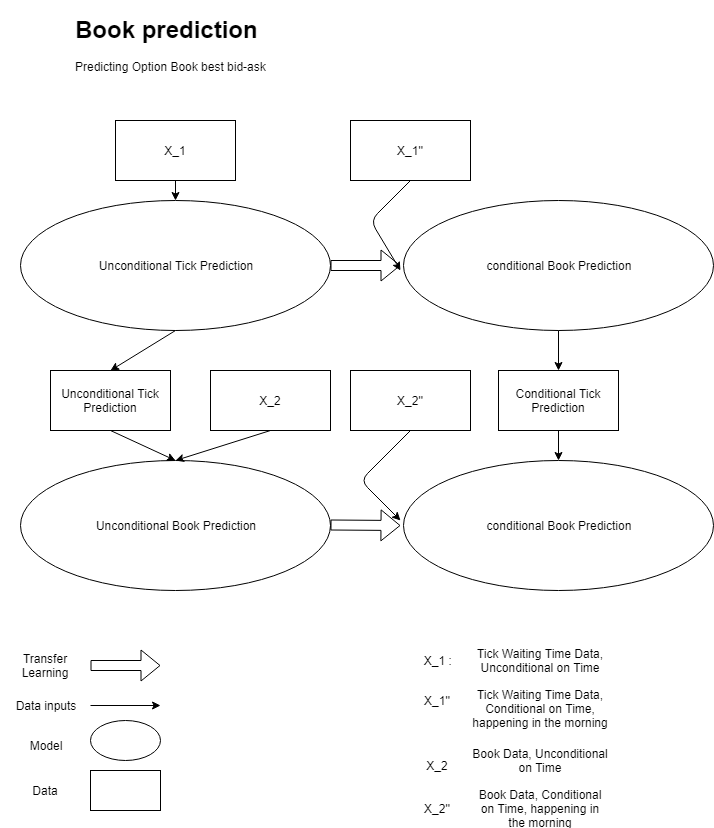

In [5]:
from IPython.display import display, Image

i = Image(filename="ModelThesis.png")
display(i)

In [6]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip
from pathlib import Path
# import L4.L4 as L4

# from pandas.plotting import parallel_coordinates
# from sklearn.mixture import GaussianMixture as GMM
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
plt.style.use('seaborn')

In [7]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [8]:

def getExpiryDate(aBook):
    anExpiryCode  = aBook[6:8]
    #hardcoded version for now. 
    myString_date = ''
    
    myString_year = ''
    myString_month = ''
    myString_day = ''
    
    #get year code
    if anExpiryCode[0] == 'L':
        myString_year = "2016"
    elif anExpiryCode[0] == 'M':
        myString_year = "2017"
    elif anExpiryCode[0] == 'N':
        myString_year = "2018"
    elif anExpiryCode[0] == 'P': #It looks strange, but that's KRX 
        myString_year = "2019"
    else : 
        sys.stderr.write("fatal error\n expiry year code unknown \n")
    
    #get month code
    myPotentialMonths = ['','1','2','3','4','5','6','7','8','9','A','B','C']

    if anExpiryCode[1] in myPotentialMonths:
        myString_month =  str(myPotentialMonths.index(anExpiryCode[1]))
    else : 
        sys.stderr.write("fatal error\n expiry month code unknown \n")    
    
    if myString_month == '':
        sys.stderr.write("fatal error\n expiry month code unknown \n")   
    #get day
    #get third Wednesday of every month, we will have to make bank holidays exceptions
    myString_day = str(calendar.Calendar(2).monthdatescalendar(int(myString_year), \
                                                               int(myString_month))[3][0].day)
    
#     print(myString_month)                   
    myString_date = myString_year+'-'+myString_month+'-'+myString_day+' 16:00:00'

    timeZone = tz.gettz('Asia/Seoul')
            
    #print("Don't forget bank holidays exceptions")
    return datetime.strptime(myString_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timeZone).astimezone(timeZone)


In [9]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

# Load Data

In [10]:
def inStrikeRange(aFutBook, aOptBook):
    '''
    look at slightly OTM or ITM options and keep that range static. Change dynamically book to keep that range
    '''
    if aFutBook == '' or aOptBook == '': #if the fut book is not itialized
        return False
    elif getBookContract(aOptBook[8:11],aOptBook[3]) is not CONTRACTTYPE.CALL : #only if Call
        return False
    
    return ((int(aOptBook[8:11]) > int(5 * np.floor((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))-5 )
    and (int(aOptBook[8:11]) < int(5 * np.ceil((aFutBook['bid_price_0']+ aFutBook['ask_price_0'])/2/5))+11))

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    '''
    aOptionStrike: enables to initialize the book to start with
    '''
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
    myLastVol = 0
    myLastVolFut = 0
    timeOfTradeFut = 0
    myFutPrice = 0
    myDTM = -1 #dayToMaturity
    
    myFirstFut = True
    myFirstOpt = True
    myFirstOptionTick =True
    myFutBook = ''
    myFutTick = ''
    myOptionBook = ''
    myPastOptionBook = ''
    myTimeList = [] #faster than nparray for appending
    myYTimeList = []
    
    myTimeListFut = []

    
    myBidAskBook = []
    myBidAskBookFut = []
    
    myYBidAskBook = []
    
    myUpperCounter = -1 #future prediction
    myLowerCounter = 0
    
    Ys = [] #to predict
    YBook = [] # to predict 
    
    myIniSecondsFut = 0
    
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        
        if myBook[5] == '1':   #it as to be a MAXI
            
            myTickCreatedTime = tick['created']/1000000 #vastly reused in the code
            TTM = (getExpiryDate(myBook) - utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))).total_seconds()/3600/24    
#             test.append(TTM)
#             print(getBookContract(myBook[8:11],myBook[3]))
#             print(TTM)


            if(getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE) and TTM<90 :
#                 print('1')
                if tick['type']=='lastdone' : 
#                     print('2')
                    if myFirstFut:
                        myFutBook = myBook
                        myFirstFut = False
                        myIniSecondsFut = np.floor(myTickCreatedTime)

                    if myFutBook == myBook:
                        myLastVolFut = (0.995*myLastVol + 0.001*(tick['volume']))
                        timeOfTradeFut = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myFutPrice = tick['price']
                        
                else:
                    
                    myFutTick = tick
       
                                
                                
            if not myFirstFut and inStrikeRange(myFutTick, myBook) and (myDTM==np.floor(TTM) or myDTM==-1) and TTM<30: #this also checks if is CALL
#                 print('3')
                    #we need to go through a first future to calculate the moneyness
                    #range we accept to look at a product (keep it not too small or it will always change book)
                myFutMid = (myFutTick['bid_price_0']+ myFutTick['ask_price_0'])/2
                #check for not initialized book or if not in range book
                if np.isnan(aOptionStrike) or not inStrikeRange(myFutTick, myOptionBook) :
                    aOptionStrike = int(5 * np.ceil(myFutMid/5))
                
                if tick['type']=='lastdone' and myBook[8:11]==str(aOptionStrike):

                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                        myDTM = np.floor(TTM)

#                     if myOptionBook == myBook:   
                    myLastVol = (0.995*myLastVol + 0.0007*(tick['volume']))
                    timeOfTrade = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
        
                if tick['type']=='tick'  and myBook[8:11]==str(aOptionStrike):
#                     print('4')
                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False

                        
                    if myFirstOptionTick:
                        myPastOptionBook = tick
                        myFirstOptionTick = False
                        myIniSeconds = np.floor(myTickCreatedTime)
                        myOldTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                        myDTM = np.floor(TTM)
                    #only interested in first 2 levels  
                    
                    if (tick['ask_volume_0'] != myPastOptionBook['ask_volume_0']) or \
                        (tick['ask_volume_1'] != myPastOptionBook['ask_volume_1']) or \
                        (tick['bid_volume_0'] != myPastOptionBook['bid_volume_0']) or \
                        (tick['bid_volume_1'] != myPastOptionBook['bid_volume_1']):
#                         print(aOptionStrike, myFutMid)                    
#                         print('5')




                        #calculate interesting past for Future

                        
                        myTimeListFut.append(myTickCreatedTime-myIniSecondsFut)
                        myBidAskBookFut.append([float(myFutTick['bid_volume_1']),float(myFutTick['bid_volume_0']),
                                                float(myFutTick['ask_volume_0']),float(myFutTick['ask_volume_1']),

                                               float(myFutTick['bid_price_1']),float(myFutTick['bid_price_0']),
                                                float(myFutTick['ask_price_0']),float(myFutTick['ask_price_1'])
                                              ]) 






                        #CALCULATE INTERESTING PAST FOR OPTION:



                        myPastOptionBook = tick
                        
                        
                        currTime = utcToRightTMZ(datetime.utcfromtimestamp(myTickCreatedTime))
                            #keep in mind the time second per sec
                        
                        myTimeList.append(myTickCreatedTime-myIniSeconds)
                        myYTimeList.append(myTickCreatedTime-myIniSeconds)
                        
                        myBidAskBook.append([float(tick['bid_volume_1']),float(tick['bid_volume_0']),
                                            float(tick['ask_volume_0']),float(tick['ask_volume_1']),
                                           
                                           float(tick['bid_price_1']),float(tick['bid_price_0']),
                                            float(tick['ask_price_0']),float(tick['ask_price_1'])
                                             ])
                        myYBidAskBook.append([float(myFutTick['bid_volume_0']),
                                                float(myFutTick['ask_volume_0']),

                                               float(myFutTick['bid_price_0']),
                                                float(myFutTick['ask_price_0'])
                                              ]) 
                                           
                        myCounter += 1
                        
 
                        #Using a ring buffer wouldn't work ... so :
                        myC3=0
                        myC1=0
                        myC05=0
                        myC025=0
                        myC01=0
                        myIdxToStartForClean=0
                        myBook1sFut = [np.NaN for x in range(0,8)]
                        myBookdot25sFut = [np.NaN for x in range(0,8)]
                        myBookdot1sFut = [np.NaN for x in range(0,8)]
                        myBookdot1s = [np.NaN for x in range(0,8)]
                        myBookdot5s = [np.NaN for x in range(0,8)]
                        
                        for idx,dtStart in enumerate(myTimeList): #I know, could do better
                            dtRecent = myTimeList[-1] - dtStart
                            dtRecentFut = myTimeListFut[-1] - dtStart
#                             print(myBidAskBook[-1])
                            bookFutDiffInPerc = [(myBidAskBookFut[-1][idx2]+0.01)/(x+0.01)-1 for idx2,x in enumerate(myBidAskBookFut[idx])]
                            bookDiffInPerc = [(myBidAskBook[-1][idx2]+0.01)/(x+0.01)-1 for idx2,x in enumerate(myBidAskBook[idx])]
#                             print('passed1')
                            if dtRecent>=3:
                                myIdxToStartForClean = idx
                                myBook1sFut = bookFutDiffInPerc
                            if dtRecent<3:
                                myC3 +=1
                            if dtRecent<1:
                                myC1 +=1
                                if dtRecent>0.5:
                                    myBookdot5s = bookDiffInPerc  #will store the book change that occured just before .5s ago
                            if dtRecent<0.5:
                                myC05 +=1 
                                if dtRecent>0.25:
                                    myBookdot25sFut = bookFutDiffInPerc
                            if dtRecent<0.25:
                                myC025 +=1 
                                if dtRecent>0.1:
                                    myBookdot1s = bookDiffInPerc #will store the book change that occured just before .1s
                                    myBookdot1sFut = bookFutDiffInPerc
                            if dtRecent<0.1:
                                myC01 +=1
                            if dtRecent<0:
                                print("issue, dt<0")
#                         print(myBookdot1s)        
                        myTimeList = myTimeList[myIdxToStartForClean:] #clean the list
                        myBidAskBook = myBidAskBook[myIdxToStartForClean:]
                        

                       #future information:
                        myTimeListFut =   myTimeListFut[myIdxToStartForClean:]          
                        myBidAskBookFut =    myBidAskBookFut[myIdxToStartForClean:]  
                        
                        
                        #it can sometimes jump some fraction of a second and leave a NaN, so correct:
                        if np.isnan(myBook1sFut).any():
                            myBook1sFut = [0 for x in range(0,8)]
                        if np.isnan(myBookdot25sFut).any():
                            myBookdot25sFut = myBook1sFut
                        if np.isnan(myBookdot1sFut).any():
                            myBookdot1sFut = myBookdot25sFut
                        if np.isnan(myBookdot1s).any():
                            myBookdot1s = [0 for x in range(0,8)]
                        if np.isnan(myBookdot5s).any():
                            myBookdot5s = myBookdot1s                       
                        
                        
                        try:
#                             print('passed3')
#                             print(myBook1sFut,myBookdot25sFut,myBookdot1sFut,myBookdot5s,myBookdot1s)
                            timeOfDay = currTime.hour \
                                        +currTime.minute/60
                                
                            moneyness = 2*myFutMid/int(myOptionBook[8:11])
                            
                            if len(myTicksOfInterest) == 0 :
                                myTicksOfInterest = np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                    15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) , \
                                                                    40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),\
                                                                    TTM, timeOfDay, moneyness, myC3/15, myC1/10, myC05/5, myC025/2, myC01,\
                                                                    myBook1sFut[0],myBook1sFut[1],myBook1sFut[2],myBook1sFut[3],\
                                                                    myBook1sFut[4],myBook1sFut[5],myBook1sFut[6],myBook1sFut[7],\
                                                                    myBookdot25sFut[0],myBookdot25sFut[1],myBookdot25sFut[2],myBookdot25sFut[3],\
                                                                    myBookdot25sFut[4],myBookdot25sFut[5],myBookdot25sFut[6],myBookdot25sFut[7],\
                                                                    myBookdot1sFut[0],myBookdot1sFut[1],myBookdot1sFut[2],myBookdot1sFut[3],\
                                                                    myBookdot1sFut[4],myBookdot1sFut[5],myBookdot1sFut[6],myBookdot1sFut[7],\
#                                                                     myBookdot1sFut[0],myBookdot1sFut[1],myBookdot1sFut[2],myBookdot1sFut[3],\
#                                                                     myBookdot1sFut[4],myBookdot1sFut[5],myBookdot1sFut[6],myBookdot1sFut[7],\
                                                                    myBookdot5s[0],myBookdot5s[1],myBookdot5s[2],myBookdot5s[3],\
                                                                    myBookdot5s[4],myBookdot5s[5],myBookdot5s[6],myBookdot5s[7],\
                                                                    myBookdot1s[0],myBookdot1s[1],myBookdot1s[2],myBookdot1s[3],\
                                                                    myBookdot1s[4],myBookdot1s[5],myBookdot1s[6],myBookdot1s[7] ])
                            else:
                                myTicksOfInterest = np.vstack( (myTicksOfInterest,np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                    15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000), \
                                                                    40*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000),\
                                                                    TTM, timeOfDay, moneyness, myC3/15, myC1/10, myC05/5, myC025/2, myC01,\
                                                                    myBook1sFut[0],myBook1sFut[1],myBook1sFut[2],myBook1sFut[3],\
                                                                    myBook1sFut[4],myBook1sFut[5],myBook1sFut[6],myBook1sFut[7],\
                                                                    myBookdot25sFut[0],myBookdot25sFut[1],myBookdot25sFut[2],myBookdot25sFut[3],\
                                                                    myBookdot25sFut[4],myBookdot25sFut[5],myBookdot25sFut[6],myBookdot25sFut[7],\
                                                                    myBookdot1sFut[0],myBookdot1sFut[1],myBookdot1sFut[2],myBookdot1sFut[3],\
                                                                    myBookdot1sFut[4],myBookdot1sFut[5],myBookdot1sFut[6],myBookdot1sFut[7],\
#                                                                     myBookdot1sFut[0],myBookdot1sFut[1],myBookdot1sFut[2],myBookdot1sFut[3],\
#                                                                     myBookdot1sFut[4],myBookdot1sFut[5],myBookdot1sFut[6],myBookdot1sFut[7],\
                                                                    myBookdot5s[0],myBookdot5s[1],myBookdot5s[2],myBookdot5s[3],\
                                                                    myBookdot5s[4],myBookdot5s[5],myBookdot5s[6],myBookdot5s[7],\
                                                                    myBookdot1s[0],myBookdot1s[1],myBookdot1s[2],myBookdot1s[3],\
                                                                    myBookdot1s[4],myBookdot1s[5],myBookdot1s[6],myBookdot1s[7] ])) )
                            #for Ys target data:
                            #Using the same list as above, taking the first element and linking to it a nb of tick wouldn't work well because of jumps, some ticks would have no info.
#                             print(myBookdot1s[4])                          
#                             print('passed4')                                                                
                            myUpperCounter += 1 #we got one element inside the condition, new tick
                        
                            #map from earlier tick
#                             print(myYTimeList)
#                             print(myYTimeList[myLowerCounter])
#                             print(myUpperCounter)
#                             print(myYTimeList[myUpperCounter])
                            while (myYTimeList[myUpperCounter]-myYTimeList[myLowerCounter])>0.4:
                                Ys.append(myUpperCounter-myLowerCounter-1)
                                YBook.append([myYBidAskBook[myLowerCounter][0]/myYBidAskBook[-1][0]-1,
                                             myYBidAskBook[myLowerCounter][1]/myYBidAskBook[-1][1]-1,
                                             myYBidAskBook[myLowerCounter][2]/myYBidAskBook[-1][2]-1,
                                             myYBidAskBook[myLowerCounter][3]/myYBidAskBook[-1][3]-1])
                                myLowerCounter += 1                                                                      
#                             print('passed5')
                        except Exception as e:
                            print(e)
                            pass #pass, not continue, continue switch to the next itirqtion
                        oldTime = currTime
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest, Ys, YBook

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * np.floor((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [11]:
from multiprocessing.dummy import Pool as ThreadPool 
import multiprocessing as mp
import gc

trainDataToLoad = ['data\\2017.10.24\\feeddata_09.json.gz','data\\2017.10.24\\feeddata_11.json.gz',
                    'data\\2017.10.25\\feeddata_10.json.gz','data\\2017.10.25\\feeddata_11.json.gz',
                    'data\\2017.04.04\\feeddata_09.json.gz','data\\2017.04.04\\feeddata_11.json.gz',
                   'data\\2017.04.05\\feeddata_09.json.gz','data\\2017.04.05\\feeddata_09.json.gz',
                    'data\\2017.10.10\\feeddata_09.json.gz','data\\2017.10.11\\feeddata_09.json.gz',
                   'data\\2017.10.12\\feeddata_09.json.gz','data\\2017.10.11\\feeddata_10.json.gz',
                   'data\\2017.11.03\\feeddata_09.json.gz','data\\2017.10.13\\feeddata_10.json.gz',
                   'data\\2017.11.01\\feeddata_12.json.gz','data\\2017.11.02\\feeddata_10.json.gz',
                   'data\\2017.11.03\\feeddata_12.json.gz','data\\2017.11.06\\feeddata_10.json.gz',                   
                  'data\\2017.11.17\\feeddata_12.json.gz','data\\2017.11.30\\feeddata_13.json.gz',
                  'data\\2017.11.20\\feeddata_12.json.gz','data\\2017.11.24\\feeddata_13.json.gz',
                  'data\\2017.11.21\\feeddata_12.json.gz','data\\2017.11.23\\feeddata_13.json.gz']

testDataToLoad = ['data\\2017.10.24\\feeddata_13.json.gz', 'data\\2017.11.24\\feeddata_11.json.gz',
                 'data\\2017.10.23\\feeddata_10.json.gz', 'data\\2017.10.25\\feeddata_11.json.gz',
                 'data\\2017.11.08\\feeddata_10.json.gz', 'data\\2017.11.06\\feeddata_10.json.gz',
                 'data\\2017.11.07\\feeddata_10.json.gz','data\\2017.11.08\\feeddata_11.json.gz',
                 'data\\2017.11.09\\feeddata_10.json.gz','data\\2017.11.10\\feeddata_10.json.gz']

#load the data
train_size = 0.9
#cleaner : keeps the file compressed on the computer


def conditionalExtractor(date,nbPoints=10000):
    '''
    extract the data of interest
    '''
    with gzip.open(date, "rb") as f:
        data = json.loads(f.read().decode("ascii"))
    
    WaitingTimeAndTrade, target = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
    WaitingTimeAndTrade = WaitingTimeAndTrade[1000:len(target)] #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
    target = np.array(target[1000:]).reshape(len(target[1000:]),1)
    
    return [WaitingTimeAndTrade,target]



# v1.1
# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):   
#     pool = ThreadPool(processes=8) 
#     results = pool.map(conditionalExtractor, dataToLoad_)
#     pool.close()
#     pool.join()
    
#     gc.collect() #clean garbage collector
#     return results

# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):   
# #     m = mp.Manager()
# #     memorizedPaths = m.dict()
#     results = []
#     # use all available CPUs
#     p = mp.Pool(mp.cpu_count())
#     for _ in p.imap_unordered(conditionalExtractor, dataToLoad_):
#         results.append(_)
#     p.close()
#     p.join()
    
#     return results
# import pp
# def loadDataIntoXsYs(dataToLoad_,nbPoints=10000):
    
#     job_server = pp.Server()
#     jobs = []
#     for data in dataToLoad_:
#         jobs.append(job_server.submit(parallel_function, (dataToLoad_,)))

    
#     job_server = pp.Server() 
    
#     return jobs



#@deprecated #v1.0
def loadDataIntoXsYs(dataToLoad_,nbPoints=25000):
    first = True
    for idx,date in enumerate(dataToLoad_):
        with gzip.open(date, "rb") as f:
            data = json.loads(f.read().decode("ascii"))
  
        if first:
            WaitingTimeAndTrade, target, bookTarget = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
            
            if len(WaitingTimeAndTrade)>2000:
                first = False
                WaitingTimeAndTrade = WaitingTimeAndTrade[1000:len(target)] #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
                target = np.array(target[1000:]).reshape(len(target[1000:]),1)
                bookTarget = np.array(bookTarget[1000:]).reshape(len(bookTarget[1000:]),4)
            else:
                print("Data hasn't enough points, error somewhere")                
        else :
            WaitingTimeAndTradeTemp, targetTemp, bookTargetTemp = extractInterestingData(nbPoints,whichStrikeAtMoney(data),data)
            #because of the exponential ,oving average, we want to cut the first bit of data out
            
            if len(WaitingTimeAndTradeTemp)>2000:
                WaitingTimeAndTrade=  np.vstack((WaitingTimeAndTrade, WaitingTimeAndTradeTemp[1000:len(targetTemp)])) 
                #we may not have the right number of ticks to make 1s in the end, forget them, and forget the init
                target = np.vstack((target,np.array(targetTemp[1000:]).reshape(len(targetTemp[1000:]),1)))
                
                bookTarget = np.vstack((bookTarget,np.array(bookTargetTemp[1000:]).reshape(len(bookTargetTemp[1000:]),4)))
            else:
                print("Data hasn't enough points, error somewhere")
        print(len(WaitingTimeAndTrade)==len(target) & len(target)==len(bookTarget))
        
        gc.collect() #clean garbage collector
    return WaitingTimeAndTrade, target, bookTarget

        

In [12]:
from multiprocessing import cpu_count
print(cpu_count())

8


In [13]:
# with gzip.open('data\\2017.10.10\\feeddata_09.json.gz', "rb") as f:
#     data = json.loads(f.read().decode("ascii"))

In [14]:

# # print(whichStrikeAtMoney(data))
# WaitingTimeAndTrade, target = extractInterestingData(20000,whichStrikeAtMoney(data),data)


In [15]:
# del data

In [16]:
#old
# WaitingTimeAndTrade, target = loadDataIntoXsYs(trainDataToLoad)

#new, requires additional processing:
  
# pool = ThreadPool(processes=8) 
# results = pool.map(conditionalExtractor, trainDataToLoad)
# pool.close()
# pool.join()

# gc.collect() #clean garbage collector


In [17]:

# WaitingTimeAndTrade, target, targetBook = loadDataIntoXsYs(trainDataToLoad,20000)


In [18]:
# len(WaitingTimeAndTrade)

In [19]:
# # testRes = loadDataIntoXsYs(testDataToLoad,5000)

# WaitingTimeAndTrade_TrueTest, target_TrueTest, targetBook_TrueTest = loadDataIntoXsYs(testDataToLoad,20000)

In [20]:
# len(WaitingTimeAndTrade_TrueTest)

In [21]:

#save these files, in case of.
def backupFiles():
    np.savetxt('XsTrain.txt', WaitingTimeAndTrade, fmt='%.7f')
    np.savetxt('YsTrain.txt', target, fmt='%.7f')
    np.savetxt('YsBookTrain.txt', targetBook, fmt='%.7f')
 
    np.savetxt('XsTest.txt', WaitingTimeAndTrade_TrueTest, fmt='%.7f')
    np.savetxt('YsTest.txt', target_TrueTest, fmt='%.7f')
    np.savetxt('YsBookTest.txt', targetBook_TrueTest, fmt='%.7f')
    
def loadBackupFiles(isX, isTrain, isBookPred):
    if isTrain:
        if isX:
            return np.loadtxt('XsTrain.txt', dtype=float) 
        else :
            if isBookPred:
                return np.loadtxt('YsBookTrain.txt', dtype=float)
            else:
                return np.loadtxt('YsTrain.txt', dtype=int)
    else:
        if isX:
            return np.loadtxt('XsTest.txt', dtype=float) 
        else :
            if isBookPred:
                return np.loadtxt('YsBookTest.txt', dtype=float)
            else:
                return np.loadtxt('YsTest.txt', dtype=int)
    

#add to our data, the backupdata ?
# WaitingTimeAndTrade = np.vstack((WaitingTimeAndTrade, loadBackupFiles(True)))
# target = np.vstack((target, loadBackupFiles(False)))

# backupFiles()

In [22]:
#load backup
WaitingTimeAndTrade = loadBackupFiles(isX=True, isTrain=True, isBookPred=False)
target = loadBackupFiles(isX=False, isTrain=True, isBookPred=False)
target = np.array(target.reshape(len(target),1))
targetBook = loadBackupFiles(isX=False, isTrain=True, isBookPred=True)
# print(targetBook.shape)
targetBook = np.array(targetBook.reshape(len(targetBook),4))


WaitingTimeAndTrade_TrueTest = loadBackupFiles(isX=True, isTrain=False, isBookPred=False)
target_TrueTest = loadBackupFiles(isX=False, isTrain=False, isBookPred=False)
target_TrueTest = np.array(target_TrueTest.reshape(len(target_TrueTest),1))
targetBook_TrueTest = loadBackupFiles(isX=False, isTrain=False, isBookPred=True)
targetBook_TrueTest = np.array(targetBook_TrueTest.reshape(len(targetBook_TrueTest),4))

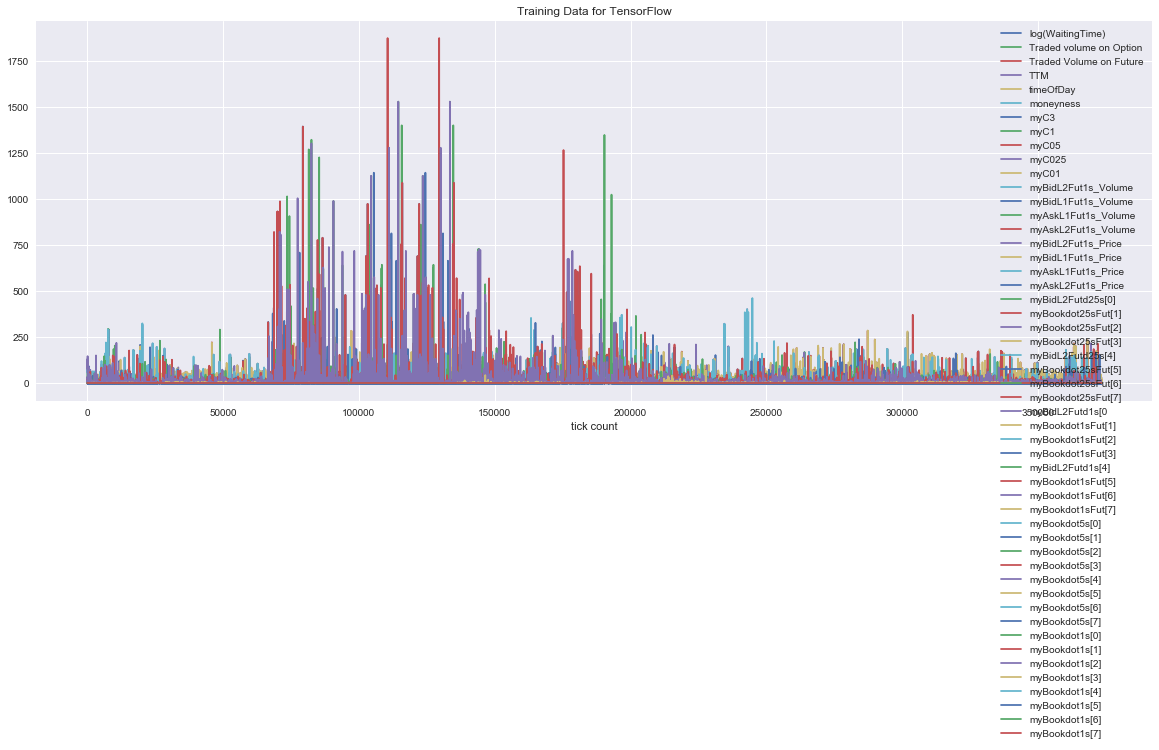

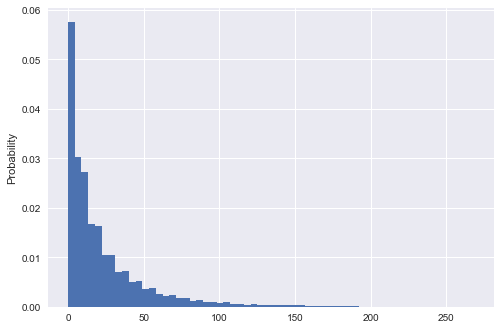

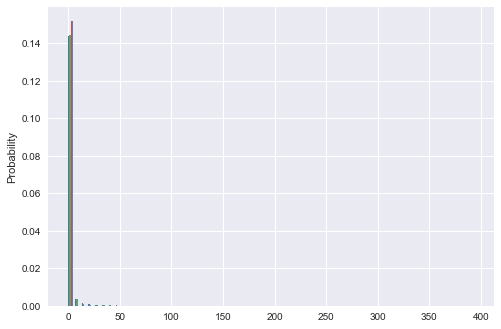

In [19]:
plt.figure(figsize=(20,7))
plt.title('Training Data for TensorFlow')
plt.plot(WaitingTimeAndTrade)
plt.legend(['log(WaitingTime)','Traded volume on Option','Traded Volume on Future','TTM', 'timeOfDay', 'moneyness',\
            'myC3', 'myC1', 'myC05', 'myC025', 'myC01',\
            'myBidL2Fut1s_Volume','myBidL1Fut1s_Volume','myAskL1Fut1s_Volume','myAskL2Fut1s_Volume',\
            'myBidL2Fut1s_Price','myBidL1Fut1s_Price','myAskL1Fut1s_Price','myAskL2Fut1s_Price',\
            'myBidL2Futd25s[0]','myBookdot25sFut[1]','myBookdot25sFut[2]','myBookdot25sFut[3]',\
            'myBidL2Futd25s[4]','myBookdot25sFut[5]','myBookdot25sFut[6]','myBookdot25sFut[7]',\
            'myBidL2Futd1s[0','myBookdot1sFut[1]','myBookdot1sFut[2]','myBookdot1sFut[3]',\
            'myBidL2Futd1s[4]','myBookdot1sFut[5]','myBookdot1sFut[6]','myBookdot1sFut[7]',\
            'myBookdot5s[0]','myBookdot5s[1]','myBookdot5s[2]','myBookdot5s[3]',\
            'myBookdot5s[4]','myBookdot5s[5]','myBookdot5s[6]','myBookdot5s[7]',\
            'myBookdot1s[0]','myBookdot1s[1]','myBookdot1s[2]','myBookdot1s[3]',\
            'myBookdot1s[4]','myBookdot1s[5]','myBookdot1s[6]','myBookdot1s[7]'])
plt.xlabel('tick count')
plt.show()

plt.hist(target, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()

plt.hist(targetBook, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()

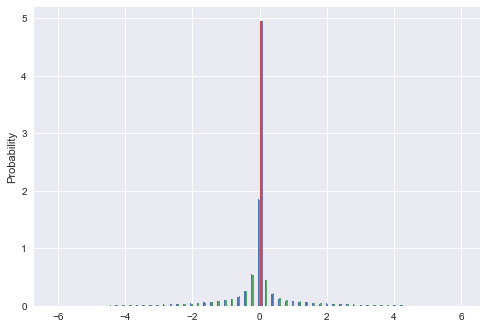

In [20]:
#should we log:
plt.hist(np.log(targetBook+1), normed=True, bins=60)
plt.ylabel('Probability')
plt.show()

In [23]:
def loadAndPreprocessData():

    global Xmean, Xstd, WaitingTimeAndTrade,WaitingTimeAndTrade_TrueTest, \
    target, targetBook, targetBook_TrueTest, x_train, x_test, y_train, y_test, \
    yBook_train, yBook_test, targetBook_mean, targetBook_std
    
    
    
    
    #load backup
    WaitingTimeAndTrade = loadBackupFiles(isX=True, isTrain=True, isBookPred=False)
    target = loadBackupFiles(isX=False, isTrain=True, isBookPred=False)
    target = np.array(target.reshape(len(target),1))
    targetBook = loadBackupFiles(isX=False, isTrain=True, isBookPred=True)
    # print(targetBook.shape)
    targetBook = np.array(targetBook.reshape(len(targetBook),4))


    WaitingTimeAndTrade_TrueTest = loadBackupFiles(isX=True, isTrain=False, isBookPred=False)
    target_TrueTest = loadBackupFiles(isX=False, isTrain=False, isBookPred=False)
    target_TrueTest = np.array(target_TrueTest.reshape(len(target_TrueTest),1))
    targetBook_TrueTest = loadBackupFiles(isX=False, isTrain=False, isBookPred=True)
    targetBook_TrueTest = np.array(targetBook_TrueTest.reshape(len(targetBook_TrueTest),4))
    
    
    
    train_size = 0.9

    #this is for, if we wanted to condition on time
    # train_cnt = int(WaitingTimeAndTrade.shape[0] * train_size)
    # x_train = WaitingTimeAndTrade[0:train_cnt]
    # y_train = target[0:train_cnt]
    # x_test = WaitingTimeAndTrade[train_cnt:]
    # y_test = target[train_cnt:]
    

    #normalization : not so important because of batch norm but doesn't create any issue
    Xmean = WaitingTimeAndTrade.mean(axis=0)
    Xstd = WaitingTimeAndTrade.std(axis=0)
    WaitingTimeAndTrade = (WaitingTimeAndTrade - Xmean)/Xstd
    WaitingTimeAndTrade_TrueTest = (WaitingTimeAndTrade_TrueTest - Xmean)/Xstd
    # targetBook_Mean = targetBook.mean()
    # targetBook_std = targetBook.std()

    targetBook = np.log(targetBook+1)
    targetBook_TrueTest = np.log(targetBook_TrueTest+1)
    
    targetBook_mean = targetBook.mean(axis=0) # important because we predict several outputs
    targetBook_std = targetBook.std(axis=0) # they need to be on the same scale.
    
    targetBook = (targetBook-targetBook_mean)/targetBook_std
    targetBook_TrueTest = (targetBook_TrueTest-targetBook_mean)/targetBook_std
    
    
    
    ONLYPRICE=True
    if ONLYPRICE:
        targetBook = np.delete(targetBook, [0,1], axis = 1)
        targetBook_TrueTest = np.delete(targetBook_TrueTest, [0,1], axis = 1)
    
    # # Y Normalization : could speed up training but we loose the simple loss meaning
    # Ymean = target.mean()
    # Ystd = target.std()
    # target = (target - Ymean)/Ystd
    

    #shuffle the array ahead of time:
    #unconditional of time:
    #we need to shuffle both arrays similarly, let's not use the train/test from sklearn

    myIndices = np.arange(len(WaitingTimeAndTrade))

    myIndicesForTrain = myIndices[0:int(train_size*len(myIndices))]
    myIndicesForTest = myIndices[int(train_size*len(myIndices)):]
    
    # = removing TTM and TimeOfDay and train these variables as transfer
    SUBTRAIN = True
    SHUFFLE = False
    
    if SUBTRAIN: #idx 3: TTM, 4:TimeOfDay
        WaitingTimeAndTrade = np.delete(np.delete(WaitingTimeAndTrade, 4, 1),3,1)
        WaitingTimeAndTrade_TrueTest = np.delete(np.delete(WaitingTimeAndTrade_TrueTest, 4, 1),3,1)
    if not SHUFFLE:
        x_train = WaitingTimeAndTrade[myIndicesForTrain]
        y_train = target[myIndicesForTrain]
        x_test = WaitingTimeAndTrade[myIndicesForTest]
        y_test = target[myIndicesForTest]
        yBook_train = targetBook[myIndicesForTrain]
        yBook_test = targetBook[myIndicesForTest]
    else:
        np.random.shuffle(myIndices)
        myIndicesForTrain = myIndices[0:int(train_size*len(myIndices))]
        myIndicesForTest = myIndices[int(train_size*len(myIndices)):]
        x_train = WaitingTimeAndTrade[myIndicesForTrain]
        y_train = target[myIndicesForTrain]
        x_test = WaitingTimeAndTrade[myIndicesForTest]
        y_test = target[myIndicesForTest]
        yBook_train = targetBook[myIndicesForTrain]
        yBook_test = targetBook[myIndicesForTest]
        
#         x_train = WaitingTimeAndTrade[:int(train_size *len(WaitingTimeAndTrade))]
#         y_train = target[:int(train_size *len(target))]
#         x_test = WaitingTimeAndTrade[int(train_size *len(WaitingTimeAndTrade)):]
#         y_test = target[int(train_size *len(target)):]
#         yBook_train = targetBook[int(train_size *len(targetBook)):]
#         yBook_test = targetBook[:int(train_size *len(target_TrueTest))]

In [24]:
len(targetBook)==len(WaitingTimeAndTrade)



True

In [25]:
# myIndices = np.arange(len(WaitingTimeAndTrade))

In [26]:
# WaitingTimeAndTrade[myIndices[0:int(train_size*len(myIndices))]].shape

In [27]:
# targetBook[int(train_size *len(targetBook)):].shape

In [28]:
# targetBook[myIndices[0:int(train_size*len(myIndices))]].shape

# TF

In [29]:
import tensorflow as tf

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [30]:
import tensorflow as tf
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
tf.reset_default_graph()

In [39]:
class unconditionalTickPredictor():
    
    
    def __init__(self,isRestoredVariables=True):
        # Small epsilon value for the BN transform
        tf.reset_default_graph()
        self.epsilon = 1e-3
        self.decay = 0.995
        self.learningNoise = 0.002
        self.learningRate = 0.00005
        
        
        self.n_hidden_1 = 50
        self.n_hidden_2 = 35
        self.n_hidden_3 = 25
        self.n_hidden_4 = 0
        

        self.training_epochs = 2000
        self.display_step = 250
        self.batch_size = 100000
        self.pathToUncVariables = "./savedModels/unconditionTick/"
        self.isRestoredVariables = isRestoredVariables
        self.gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth = False) 

        
        self.preprocessData() # preprocess the data for the learning
        self.n_input = x_train.shape[1] #after variable is preprocessed 
        
#         self.setVariables(isRestoredVariables)
        self.setVarInTemp()
        tf.reset_default_graph()       
        
        

        
    def preprocessData(self):
        print('preprocessing data... please wait')
        loadAndPreprocessData()
        print('data processed')
        print('training data has shape' + str(x_train.shape) )
    

    def setSavers(self):
        # Define savers for explicit subsets of the variables.
#         self.weights_saver = tf.train.Saver(var_list= self.weights)
#         self.biases_saver = tf.train.Saver(var_list= self.biases)
#         self.gammas_saver = tf.train.Saver(var_list = self.gammas)
#         self.pop_mean_saver = tf.train.Saver(var_list = self.pop_mean)
#         self.pop_var_saver = tf.train.Saver(var_list = self.pop_var)

        self.wholeModelSaver = tf.train.Saver()
    
    
    def setVarInTemp(self):
        
                    #I keep it this way to have a lower level implementation (just for me, not so useful nor performant)

        #xavier initialization modified to take into account the no symmetric leaky relu:
        #we would multiply by sqrt(2) with relu, lrelu will have a slope on the negative values, which is by default .2
        #se we multiply by sqrt(2/1.2) = sqrt(1.67)
        # with tf.device('/GPU:0'):
        if not self.isRestoredVariables:
            with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
                self.tempWeights = {
                    '1': sess.run(tf.random_normal([self.n_input, self.n_hidden_1], mean=0, stddev=tf.sqrt(2*1.67/(self.n_input+self.n_hidden_1)))),
                    '2': sess.run(tf.random_normal([self.n_hidden_1, self.n_hidden_2], mean=0, stddev=tf.sqrt(2*1.67/(self.n_hidden_1+self.n_hidden_2)))),
                    '3': sess.run(tf.random_normal([self.n_hidden_2, self.n_hidden_3], mean=0, stddev=tf.sqrt(2*1.67/(self.n_hidden_2+self.n_hidden_3)))), 
                #     '4': tf.random_normal([n_hidden_3, n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4))),
                    'out': sess.run(tf.random_normal([self.n_hidden_3, 1], mean=0, stddev=tf.sqrt(2*1.67/(1+self.n_hidden_3)))),
                }

                self.tempGammas = {
                    '1': sess.run(tf.ones([self.n_hidden_1])), #no scale for output, start at 1
                    '2': sess.run(tf.ones([self.n_hidden_2])), 
                    '3': sess.run(tf.ones([self.n_hidden_3])) 
                #     '4': tf.Variable(tf.ones([n_hidden_4]))
                }

                #common to initialize biases at 0
                self.tempBiases = {
                    '1': sess.run(tf.zeros([self.n_hidden_1])), 
                    '2': sess.run(tf.zeros([self.n_hidden_2])), 
                    '3': sess.run(tf.zeros([self.n_hidden_3])), 
                    'out': sess.run(tf.zeros([1]) ) #keep bias for output
                }

                self.tempPop_mean = {
                    '1' : sess.run(tf.zeros([self.n_hidden_1])),  #size depends if after or before relu 
                    '2' : sess.run(tf.zeros([self.n_hidden_2])), 
                    '3' : sess.run(tf.zeros([self.n_hidden_3]))
                }

                self.tempPop_var = {
                    '1' : sess.run(tf.ones([self.n_hidden_1])), 
                    '2' : sess.run(tf.ones([self.n_hidden_2])), 
                    '3' : sess.run(tf.ones([self.n_hidden_3]))
                }
        else:
            with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
                new_saver = tf.train.import_meta_graph(self.pathToUncVariables + 'Model/model.meta')
                new_saver.restore(sess, self.pathToUncVariables + 'Model/model')

                    #     print(sess.run(sess.graph.get_tensor_by_name("w1:0")))
                    #     with tf.device('/GPU:0'):

                self.tempWeights =  {
                    '1': sess.run(sess.graph.get_tensor_by_name("w1-tu:0")),
                    '2': sess.run(sess.graph.get_tensor_by_name("w2-tu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("w3-tu:0")),
    #                 '4': sess.graph.get_tensor_by_name("w4-tu:0"),
                    'out':sess.run(sess.graph.get_tensor_by_name("wout-tu:0"))
                }

    #             print(type(self.tempWeights))
    #             print(self.tempWeights['1'])

                self.tempGammas = {
                    '1': sess.run(sess.graph.get_tensor_by_name("g1-tu:0")), 
                    '2': sess.run(sess.graph.get_tensor_by_name("g2-tu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("g3-tu:0")),
    #                 '4': sess.graph.get_tensor_by_name("g4-tu:0")
                }

                self.tempBiases = {
                    '1': sess.run(sess.graph.get_tensor_by_name("b1-tu:0")),
                    '2': sess.run(sess.graph.get_tensor_by_name("b2-tu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("b3-tu:0")),
    #                 '4': sess.graph.get_tensor_by_name("b4-tu:0"),
                    'out': sess.run(sess.graph.get_tensor_by_name("bout-tu:0")) #keep bias for output
                }

                self.tempPop_mean = {
                    '1' : sess.run(sess.graph.get_tensor_by_name("pm1-tu:0")), #size depends if after or before relu 
                    '2' : sess.run(sess.graph.get_tensor_by_name("pm2-tu:0")),
                    '3' : sess.run(sess.graph.get_tensor_by_name("pm3-tu:0")),
    #                 '4' : sess.graph.get_tensor_by_name("pm4-tu:0")
                }


                self.tempPop_var = {
                    '1' : sess.run(sess.graph.get_tensor_by_name("pv1-tu:0")),
                    '2' : sess.run(sess.graph.get_tensor_by_name("pv2-tu:0")),
                    '3' : sess.run(sess.graph.get_tensor_by_name("pv3-tu:0")),
    #                 '4' : sess.graph.get_tensor_by_name("pv4-tu:0")
                }

    
    def setVariables(self, isRestoredVariables):
        

        self.weights = {
            '1': tf.Variable(self.tempWeights["1"] , name='w1-tu'),
            '2': tf.Variable(self.tempWeights["2"] , name='w2-tu'),
            '3': tf.Variable(self.tempWeights["3"] , name='w3-tu'),
        #     '4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4)))),
            'out': tf.Variable(self.tempWeights["out"] , name = 'wout-tu')
        }

        self.gammas = {
            '1': tf.Variable(self.tempGammas["1"] , name = 'g1-tu'), #no scale for output, start at 1
            '2': tf.Variable(self.tempGammas["2"] , name = 'g2-tu'),
            '3': tf.Variable(self.tempGammas["3"] , name = 'g3-tu')
        #     '4': tf.Variable(tf.ones([n_hidden_4]))
        }

        #common to initialize biases at 0
        self.biases = {
            '1': tf.Variable(self.tempBiases["1"] , name = 'b1-tu'),
            '2': tf.Variable(self.tempBiases["2"] , name = 'b2-tu'),
            '3': tf.Variable(self.tempBiases["3"] , name = 'b3-tu'),
            'out': tf.Variable(self.tempBiases["out"] , name = 'bout-tu') #keep bias for output
        }

        self.pop_mean = {
            '1' : tf.Variable(self.tempPop_mean["1"] , name = 'pm1-tu', trainable=False), #size depends if after or before relu 
            '2' : tf.Variable(self.tempPop_mean["2"] , name = 'pm2-tu', trainable=False),
            '3' : tf.Variable(self.tempPop_mean["3"] , name = 'pm3-tu', trainable=False)
        }

        self.pop_var = {
            '1' : tf.Variable(self.tempPop_var["1"] , name = 'pv1-tu', trainable=False),
            '2' : tf.Variable(self.tempPop_var["2"] , name = 'pv2-tu', trainable=False),
            '3' : tf.Variable(self.tempPop_var["3"] , name = 'pv3-tu', trainable=False)
        }
        
        
            
        # writeup = tf.Variable(tf.ones([10,  n_input]))
        # keep_prob = tf.placeholder("float")
        self.isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining-tu")
        self.L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization-tu")
        self.L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization-tu")

        self.x = tf.placeholder("float", [None, self.n_input], name="inputs-tu")
        self.y = tf.placeholder("float", [None, 1], name="TrueLabel-tu")
    
        
    
    
    def gaussian_noise_layer(self,input_layer, std):
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
        return tf.add(input_layer,noise)

    def batch_norm_wrapper(self,inputs, n_layer , is_training):

        if is_training is not None:
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(self.pop_mean[n_layer] ,
                                   tf.add(tf.multiply(self.pop_mean[n_layer], self.decay), tf.multiply(batch_mean, tf.subtract(1.0, self.decay))))
            train_var = tf.assign(self.pop_var[n_layer] ,
                                  tf.add(tf.multiply(self.pop_var[n_layer], self.decay), tf.multiply(batch_var, tf.subtract(1.0, self.decay))))

            with tf.control_dependencies([train_mean, train_var]):
                return tf.add(tf.div(tf.multiply(self.gammas[n_layer], tf.subtract(inputs, batch_mean)),tf.sqrt(tf.add(batch_var, self.epsilon)))\
                        ,self.biases[n_layer])
        else:
            return tf.add(tf.div(tf.multiply(self.gammas[n_layer], tf.subtract(inputs, self.pop_mean[n_layer])),tf.sqrt(tf.add(self.pop_var[n__layer], self.epsilon)))\
                    , self.biases[n_layer])

    def multilayer_perceptron(self,x, weights, biases, isTraining):
        #without batch norm:
    #     layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    #     layer_1 = tf.nn.leaky_relu(layer_1)
    #     layer_1 = tf.nn.dropout(layer_1, keep_prob)
    #     out_layer = tf.matmul(layer_1, weights['out']) + biases['out']


        #with batch norm, no bias:
        #why isn't the added noise an issue to learn ?
        if isTraining is not None:
            layer_1 = tf.matmul(self.gaussian_noise_layer(x,self.learningNoise), self.weights['1'])
        else:
            layer_1 = tf.matmul(x, self.weights['1'])


        # Calculate batch mean and variance
    #     batch_mean1, batch_var1 = tf.nn.moments(layer_1,[0])
        #original paper and Ian Goodfellow :
    #     layer_1 = (layer_1 - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    #     layer_1 = gammas['g1'] * layer_1 + biases['b1']
        #learn scaler and bias as parameters

        layer_1 = self.batch_norm_wrapper(layer_1,'1', isTraining) #dirty isTraining
        layer_1 = tf.nn.leaky_relu(layer_1)
        #recent comment from François Chollet recommand BN after activation:
        #https://github.com/keras-team/keras/issues/1802#issuecomment-187966878
    #     tf.stack([x, tf.square(x)], axis=1)


    #     #Residual net:
    #     # Get the number of rows in the fed value at run-time.
    #     layer1_num_rows = tf.shape(layer_1)[0]

    #     # Makes a `rows x 2` matrix, by tiling `x` along the row dimension.
    #     x_tiled = tf.tile(x, tf.stack([layer1_num_rows, 1]))
    #     layer_1 = tf.concat([layer_1, x_tiled], axis = 0)

    #     dim = tf.shape(x)[0]
    # #     y1 = tf.expand_dims(x, axis = 1)
    #     y1 = tf.tile(x, [dim, 1])
    #     layer_1 = tf.concat((layer_1, y1), axis = 1)

        if isTraining is not None:
            layer_1 = tf.nn.dropout(layer_1, 0.7)
        else:
            layer_1 = tf.nn.dropout(layer_1, 1)


        #dropout
    #     layer_1 = tf.nn.dropout(layer_1, keep_prob)


        #create second layer:
        layer_2 = tf.matmul(layer_1, self.weights['2'])
        layer_2 = tf.nn.leaky_relu(layer_2)
        layer_2 = self.batch_norm_wrapper(layer_2,'2', isTraining)
    #     layer_2 = tf.nn.dropout(layer_2, keep_prob)

        #create third layer:
        layer_3 = tf.matmul(layer_2, self.weights['3'])
        layer_3 = tf.nn.leaky_relu(layer_3)
        layer_3 = self.batch_norm_wrapper(layer_3,'3', isTraining)    

        if isTraining is not None:
            layer_3 = tf.nn.dropout(layer_3, 0.7)
        else:
            layer_3 = tf.nn.dropout(layer_3, 1)

        if(self.n_hidden_4>0):
            #create fourth layer:
            layer_4 = tf.matmul(layer_3, self.weights['4'])
            layer_4 = tf.nn.leaky_relu(layer_4)   
        else: 
            layer_4=layer_3

        out_layer = tf.add(tf.matmul(layer_4, self.weights['out']), self.biases['out'])
        if isTraining is not None:
            out_layer = self.gaussian_noise_layer(out_layer,self.learningNoise)

        return out_layer

    def iniModelForSess(self):
        
        # with tf.device('/GPU:0'):
        self.predictions = self.multilayer_perceptron(self.x, self.weights, self.biases, self.isTraining)

        #if regularizing
        self.regularizersL1 = tf.reduce_mean(tf.square(self.weights['3'])) #regularization on last layer
        self.regularizersL2 =  tf.reduce_mean(tf.abs(self.weights['3']))  

        self.absCost = tf.reduce_mean(tf.abs(self.predictions - self.y)) 
        self.cost = tf.reduce_mean(tf.square(self.predictions - self.y)) 

        self.regLoss = tf.add(tf.multiply(tf.add(self.cost, self.L2Regularization), self.regularizersL1),\
                              tf.multiply(self.L1Regularization,self.regularizersL2))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learningRate).minimize(self.regLoss)
    
    
    # if unshuffled beforehand or if want to add randomness to avoid overfitting batches
    def next_batch(self,xdata,ydata,batch_size,normalize=False):
        #complete random batching + normalization

        nbLabels = xdata.shape[1]
        # Grab a random starting point for each batch
        rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int64') #int16 might not be enough
        #https://github.com/tensorflow/tensorflow/issues/9506 : int32 buggy

    #     if normalize:
             #not yet implemented

        return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 1) #check input size

    
    def train(self, training_epochs=None):
        if np.isnan(training_epochs):
            self.training_epochs=2000
        else:
            self.training_epochs=training_epochs
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
            
            self.setVariables(self.isRestoredVariables)
            self.iniModelForSess()
            
            self.setSavers()
            sess.run(tf.global_variables_initializer())
#             if self.isRestoredVariables:
#                 print('running restored variables')
#                 new_saver = tf.train.import_meta_graph("./savedModels/unconditionTick/Model/model.meta")
#                 new_saver.restore(sess, "./savedModels/unconditionTick/Model/model")
            total_batch = int(len(x_train) / self.batch_size)

            for epoch in range(self.training_epochs):
                avg_cost = 0.0
        #         
        #         x_batches = np.array_split(x_train, total_batch)
        #         y_batches = np.array_split(y_train, total_batch)

                for i in range(total_batch):

                    batch_x, batch_y = self.next_batch(x_train, y_train, self.batch_size,i)
                    _, c = sess.run([self.optimizer, self.absCost], 
                                    feed_dict={
                                        self.x: batch_x, 
                                        self.y: batch_y, 
                                        self.isTraining: True,
                                        self.L1Regularization:0.0001,
                                        self.L2Regularization:0.00001
                                    })

                    avg_cost += c / total_batch

                if epoch % self.display_step == 0:
                    tc = sess.run(self.absCost, feed_dict={
                                        self.x: x_test, 
                                        self.y: y_test, 
#                                         self.isTraining: False,
                                        self.L1Regularization:0.000,
                                        self.L2Regularization:0.000
                                        })
                    true_tc=  \
                    sess.run(self.absCost, feed_dict={
                                        self.x: WaitingTimeAndTrade_TrueTest, 
                                        self.y: target_TrueTest, 
#                                         self.isTraining: False,
                                        self.L1Regularization:0.000,
                                        self.L2Regularization:0.000
                                        })
                    print("Epoch:", '%04d' % (epoch+1), "train cost=", \
                        "{:.4f}".format(avg_cost), "test cost=", \
                        "{:.4f}".format(tc),"true test cost=", \
                        "{:.4f}".format(true_tc))
        #             print(sess.run(weights['1']))
#                     self.weights_saver.save(sess, './savedModels/unconditionTick/Weights/weights')
#                     self.biases_saver.save(sess, './savedModels/unconditionTick/Biases/biases')
#                     self.gammas_saver.save(sess, './savedModels/unconditionTick/Gammas/gammas')
#                     self.pop_mean_saver.save(sess, './savedModels/unconditionTick/Pop_mean/pop_mean')
#                     self.pop_var_saver.save(sess, './savedModels/unconditionTick/Pop_var/pop_var')
                    self.wholeModelSaver.save(sess, self.pathToUncVariables+'Model/model')
            print("Optimization Finished!")
            
    def predict(self,X):
        tf.reset_default_graph()    
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
#             if self.isRestoredVariables:
            print('running restored variables')
            self.setVariables(True)
            self.iniModelForSess()
            self.setSavers()
            sess.run(tf.global_variables_initializer())
#             else:
#                 raise('not implemented')
            yhat = sess.run(self.predictions, feed_dict={
                    self.x: X, 
#                     self.isTraining: False,
                    self.L1Regularization:0.000,
                    self.L2Regularization:0.000
                    })
            self.wholeModelSaver.save(sess, self.pathToUncVariables+'Model/model')
        return yhat
    
    def getErrorPredict(self,X,y):
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
#             if self.isRestoredVariables:
            print('running restored variables')
            self.setVariables(True)
            self.iniModelForSess()
            self.setSavers()
            sess.run(tf.global_variables_initializer())
#             else:
#                 raise('not implemented')
            yhat = sess.run(self.absCost, feed_dict={
                    self.x: X,
                    self.y: y,
#                     self.isTraining: False,
                    self.L1Regularization:0.000,
                    self.L2Regularization:0.000
                    })
            self.wholeModelSaver.save(sess, self.pathToUncVariables+'Model/model')
        return yhat

In [40]:
myUncondiTickDNN = unconditionalTickPredictor(isRestoredVariables=False)

preprocessing data... please wait
data processed
training data has shape(336058, 49)


In [41]:
myUncondiTickDNN.train(253)

Epoch: 0001 train cost= 24.1669 test cost= 17.1394 true test cost= 22.1999
Epoch: 0251 train cost= 23.8814 test cost= 17.0477 true test cost= 22.0143
Optimization Finished!


In [42]:
myUncondiTickDNN = unconditionalTickPredictor(True)
myUncondiTickDNN.getErrorPredict(WaitingTimeAndTrade_TrueTest,target_TrueTest)

preprocessing data... please wait
data processed
training data has shape(336058, 49)
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Model/model
running restored variables


22.004791

In [43]:
myUncondiTickDNN = unconditionalTickPredictor(True)
myUncondiTickDNN.getErrorPredict(WaitingTimeAndTrade_TrueTest,target_TrueTest)

preprocessing data... please wait
data processed
training data has shape(336058, 49)
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Model/model
running restored variables


22.012007

In [44]:
myUncondiTickDNN = unconditionalTickPredictor(True)
myUncondiTickDNN.getErrorPredict(WaitingTimeAndTrade_TrueTest,target_TrueTest)

preprocessing data... please wait
data processed
training data has shape(336058, 49)
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Model/model
running restored variables


22.014034

In [30]:
#is it worst than constant value, i.e. stupid benchmark?
print(np.mean(np.abs(target_TrueTest-14)))
print(np.mean(np.abs(y_test-8)))


16.924947648624666


NameError: name 'y_test' is not defined

In [ ]:
myCol = ['log(WaitingTime)','Traded volume on Option','Traded Volume on Future','moneyness', 'myC3', 'myC1', 'myC05', 'myC025', 'myC01']
for i in range(x_train.shape[1]):
    plt.plot(x_train[:,i], label = myCol[i] )
    plt.legend()
    plt.show()
plt.plot(y_train)
plt.show()

In [ ]:
plt.plot(y_test)
plt.show()
plt.plot(target_TrueTest)
plt.show()

In [ ]:
plt.hist(y_test, normed=True, bins=60)
plt.ylabel('Probability')
plt.show()
plt.hist(target_TrueTest, normed=True, bins=60)
plt.ylabel('Probability')

plt.show()

# Benchmark the neuron with a simpler model from sklearn, am I still overfitting the test set ? How come !!


In [70]:
from sklearn.metrics import mean_absolute_error

In [71]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
myModel_backtest1 = RandomForestRegressor(n_estimators = 30, n_jobs=3, max_depth=4)
myModel_backtest1.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest1.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest1.predict(WaitingTimeAndTrade_TrueTest)))

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


14.803871415686253 13.733428148636143


In [73]:
from sklearn.linear_model import ElasticNet

In [74]:
myModel_backtest2 = ElasticNet()
myModel_backtest2.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest2.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest2.predict(WaitingTimeAndTrade_TrueTest)))

15.388514953954088 13.721091247267152


In [75]:
from sklearn.neural_network import MLPRegressor

In [143]:
myModel_backtest3 = MLPRegressor(hidden_layer_sizes=(40,30,20))
myModel_backtest3.fit(x_train, y_train)
print(mean_absolute_error(y_train,myModel_backtest3.predict(x_train)),mean_absolute_error(target_TrueTest,myModel_backtest3.predict(WaitingTimeAndTrade_TrueTest)))

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


12.506334951948851 13.15072839352896


# now conditional

In [58]:
class conditionalTickPredictor():
    
    
    def __init__(self, isRestoredVariables):
        tf.reset_default_graph()
        # Small epsilon value for the BN transform
        self.epsilon = 1e-3
        self.decay = 0.995
        self.learningNoise = 0.002
        self.learningRate = 0.00005
        
        
        self.n_hidden_1 = 50
        self.n_hidden_2 = 35
        self.n_hidden_3 = 25
        self.n_hidden_4 = 10
        

        self.training_epochs = 2000
        self.display_step = 250
        self.batch_size = 100000
        self.gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth = False)
        self.pathToOldVariables = "./savedModels/unconditionTick/"
        self.pathToCondVariables = "./savedModels/conditionTick/"
        
        self.isRestoredVariables = isRestoredVariables
#         if not isRestoredVariables:
#             print("Will load unconditional tick session parameters")
        self.setVarInTemp()
#         else:
#             print("Will load past conditional tick session")
            

        
        tf.reset_default_graph()
        
        self.preprocessData() # preprocess the data for the learning
        tf.reset_default_graph()
        self.n_input = x_train.shape[1] #after variable is preprocessed 
        


        
    def preprocessData(self):
        print('preprocessin data... please wait')
        loadAndPreprocessData()
        print('data processed')
        print('training data has shape' + str(x_train.shape) )
    

    def setSavers(self):
        # Define savers for explicit subsets of the variables.
#         self.weights_saver = tf.train.Saver(var_list= self.weights)
#         self.biases_saver = tf.train.Saver(var_list= self.biases)
#         self.gammas_saver = tf.train.Saver(var_list = self.gammas)
#         self.pop_mean_saver = tf.train.Saver(var_list = self.pop_mean)
#         self.pop_var_saver = tf.train.Saver(var_list = self.pop_var)
        self.wholeModelSaver = tf.train.Saver()
    
    def setVarInTemp(self):
        
        if not self.isRestoredVariables:
            with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:

                new_saver = tf.train.import_meta_graph(self.pathToOldVariables + 'Model/model.meta')
                new_saver.restore(sess, self.pathToOldVariables + 'Model/model')

                    #     print(sess.run(sess.graph.get_tensor_by_name("w1:0")))
                    #     with tf.device('/GPU:0'):

                self.tempWeights =  {
                    '1': sess.run(sess.graph.get_tensor_by_name("w1-tu:0")),
                    '2': sess.run(sess.graph.get_tensor_by_name("w2-tu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("w3-tu:0")),
                    '4': sess.run(tf.random_normal([self.n_hidden_3, self.n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(self.n_hidden_3+self.n_hidden_4)))),
                    'out': sess.run(tf.random_normal([self.n_hidden_4, 1], mean=0, stddev=tf.sqrt(2*1.67/(self.n_hidden_3+self.n_hidden_4))))
                }

    #             print(type(self.tempWeights))
    #             print(self.tempWeights['1'])

                self.tempGammas = {
                    '1': sess.run(sess.graph.get_tensor_by_name("g1-tu:0")), 
                    '2': sess.run(sess.graph.get_tensor_by_name("g2-tu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("g3-tu:0")),
                    '4': sess.run(tf.ones([self.n_hidden_4]))
                #     '4': tf.Variable(tf.ones([n_hidden_4]))
                }

                self.tempBiases = {
                    '1': sess.run(sess.graph.get_tensor_by_name("b1-tu:0")),
                    '2': sess.run(sess.graph.get_tensor_by_name("b2-tu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("b3-tu:0")),
                    '4': sess.run(tf.zeros([self.n_hidden_4])),
                    'out': sess.run(tf.zeros([1])) #keep bias for output
                }

                self.tempPop_mean = {
                    '1' : sess.run(sess.graph.get_tensor_by_name("pm1-tu:0")), #size depends if after or before relu 
                    '2' : sess.run(sess.graph.get_tensor_by_name("pm2-tu:0")),
                    '3' : sess.run(sess.graph.get_tensor_by_name("pm3-tu:0")),
                    '4' : sess.run(tf.zeros([self.n_hidden_4]))
                }


                self.tempPop_var = {
                    '1' : sess.run(sess.graph.get_tensor_by_name("pv1-tu:0")),
                    '2' : sess.run(sess.graph.get_tensor_by_name("pv2-tu:0")),
                    '3' : sess.run(sess.graph.get_tensor_by_name("pv3-tu:0")),
                    '4' : sess.run(tf.ones([self.n_hidden_4]))
                }
        else: 
            with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:

                new_saver = tf.train.import_meta_graph(self.pathToCondVariables + 'Model/model.meta')
                new_saver.restore(sess, self.pathToCondVariables + 'Model/model')

                    #     print(sess.run(sess.graph.get_tensor_by_name("w1:0")))
                    #     with tf.device('/GPU:0'):

                self.tempWeights =  {
                    '1': sess.run(sess.graph.get_tensor_by_name("w1-tc:0")),
                    '2': sess.run(sess.graph.get_tensor_by_name("w2-tc:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("w3-tc:0")),
                    '4': sess.run(sess.graph.get_tensor_by_name("w4-tc:0")),
                    'out': sess.run(sess.graph.get_tensor_by_name("wout-tc:0"))
                }

    #             print(type(self.tempWeights))
    #             print(self.tempWeights['1'])

                self.tempGammas = {
                    '1': sess.run(sess.graph.get_tensor_by_name("g1-tc:0")), 
                    '2': sess.run(sess.graph.get_tensor_by_name("g2-tc:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("g3-tc:0")),
                    '4': sess.run(sess.graph.get_tensor_by_name("g4-tc:0"))
                #     '4': tf.Variable(tf.ones([n_hidden_4]))
                }

                self.tempBiases = {
                    '1': sess.run(sess.graph.get_tensor_by_name("b1-tc:0")),
                    '2': sess.run(sess.graph.get_tensor_by_name("b2-tc:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("b3-tc:0")),
                    '4': sess.run(sess.graph.get_tensor_by_name("b4-tc:0")),
                    'out': sess.run(sess.graph.get_tensor_by_name("bout-tc:0")), #keep bias for output
                }

                self.tempPop_mean = {
                    '1' : sess.run(sess.graph.get_tensor_by_name("pm1-tc:0")), #size depends if after or before relu 
                    '2' : sess.run(sess.graph.get_tensor_by_name("pm2-tc:0")),
                    '3' : sess.run(sess.graph.get_tensor_by_name("pm3-tc:0")),
                    '4' : sess.run(sess.graph.get_tensor_by_name("pm4-tc:0"))
                }


                self.tempPop_var = {
                    '1' : sess.run(sess.graph.get_tensor_by_name("pv1-tc:0")),
                    '2' : sess.run(sess.graph.get_tensor_by_name("pv2-tc:0")),
                    '3' : sess.run(sess.graph.get_tensor_by_name("pv3-tc:0")),
                    '4' : sess.run(sess.graph.get_tensor_by_name("pv4-tc:0"))
                }
                
                
                
                
                
    def setVariables(self,isRestoredVariables):
        
        self.weights = {
            '1': tf.Variable(self.tempWeights['1'], name='w1-tc', trainable=False),#restored
            '2': tf.Variable(self.tempWeights['2'], name='w2-tc', trainable=False),#restored
            '3': tf.Variable(self.tempWeights['3'], name='w3-tc', trainable=False),#restored
            '4': tf.Variable(self.tempWeights['4'] , name='w4-tc'),
            'out': tf.Variable(self.tempWeights['out'] , name='wout-tc')
        }

    #     with tf.device('/GPU:0'):
        self.gammas = {
            '1': tf.Variable(self.tempGammas['1'] , name = 'g1-tc', trainable=False), #restored
            '2': tf.Variable(self.tempGammas['2'] , name = 'g2-tc', trainable=False),#restored
            '3': tf.Variable(self.tempGammas['3'] , name = 'g3-tc', trainable=False),#restored
            '4': tf.Variable(self.tempGammas['4'] , name = 'g4-tc')
        #     '4': tf.Variable(tf.ones([n_hidden_4]))
        }


        #common to initialize biases at 0
    #     with tf.device('/GPU:0'):
        self.biases = {
            '1': tf.Variable(self.tempBiases['1'] , name = 'b1-tc', trainable=False), #restored
            '2': tf.Variable(self.tempBiases['2'] , name = 'b2-tc', trainable=False), #restored
            '3': tf.Variable(self.tempBiases['3'] , name = 'b3-tc', trainable=False), #restored
            '4': tf.Variable(self.tempBiases['4'] , name = 'b4-tc'),
            'out': tf.Variable(self.tempBiases['out'] , name = 'bout-tc') #keep bias for output
        }


    #     with tf.device('/GPU:0'):
        self.pop_mean = {
            '1' : tf.Variable(self.tempPop_mean['1'] , name = 'pm1-tc', trainable=False),  #restored
            '2' : tf.Variable(self.tempPop_mean['2'] , name = 'pm2-tc', trainable=False), #restored
            '3' : tf.Variable(self.tempPop_mean['3'] , name = 'pm3-tc', trainable=False), #restored
            '4' : tf.Variable(self.tempPop_mean['4'] , name = 'pm4-tc'),
        }


    #     with tf.device('/GPU:0'):
        self.pop_var = {
            '1' : tf.Variable(self.tempPop_var['1'] , name = 'pv1-tc', trainable=False), #restored
            '2' : tf.Variable(self.tempPop_var['2'] , name = 'pv2-tc', trainable=False), #restored
            '3' : tf.Variable(self.tempPop_var['3'] , name = 'pv3-tc', trainable=False), #restored
            '4' : tf.Variable(self.tempPop_var['4'] , name = 'pv4-tc')
        }
            
            
            
        # writeup = tf.Variable(tf.ones([10,  n_input]))
        # keep_prob = tf.placeholder("float")
        self.isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining-tc")
        self.L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization-tc")
        self.L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization-tc")

        self.x = tf.placeholder("float", [None, self.n_input], name="inputs-tc")
        self.y = tf.placeholder("float", [None, 1], name="TrueLabel-tc")
    
        
    
    
    def gaussian_noise_layer(self,input_layer, std):
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
        return tf.add(input_layer,noise)

    def batch_norm_wrapper(self,inputs, n_layer , is_training):

        if is_training is not None:
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(self.pop_mean[n_layer] ,
                                   tf.add(tf.multiply(self.pop_mean[n_layer], self.decay), tf.multiply(batch_mean, tf.subtract(1.0, self.decay))))
            train_var = tf.assign(self.pop_var[n_layer] ,
                                  tf.add(tf.multiply(self.pop_var[n_layer], self.decay), tf.multiply(batch_var, tf.subtract(1.0, self.decay))))

            with tf.control_dependencies([train_mean, train_var]):
                return tf.add(tf.div(tf.multiply(self.gammas[n_layer], tf.subtract(inputs, batch_mean)),tf.sqrt(tf.add(batch_var, self.epsilon)))\
                        ,self.biases[n_layer])
        else:
            return tf.add(tf.div(tf.multiply(self.gammas[n_layer], tf.subtract(inputs, self.pop_mean[n_layer])),tf.sqrt(tf.add(self.pop_var[n__layer], self.epsilon)))\
                    , self.biases[n_layer])

    def multilayer_perceptron(self,x, weights, biases, isTraining):

        if isTraining is not None:
            layer_1 = tf.matmul(self.gaussian_noise_layer(x,self.learningNoise), self.weights['1'])
        else:
            layer_1 = tf.matmul(x, self.weights['1'])



        layer_1 = self.batch_norm_wrapper(layer_1,'1', isTraining) #dirty isTraining
        layer_1 = tf.nn.leaky_relu(layer_1)

        if isTraining is not None:
            layer_1 = tf.nn.dropout(layer_1, 0.7)
        else:
            layer_1 = tf.nn.dropout(layer_1, 1)

        #create second layer:
        layer_2 = tf.matmul(layer_1, self.weights['2'])
        layer_2 = tf.nn.leaky_relu(layer_2)
        layer_2 = self.batch_norm_wrapper(layer_2,'2', isTraining)

        #create third layer:
        layer_3 = tf.matmul(layer_2, self.weights['3'])
        layer_3 = tf.nn.leaky_relu(layer_3)
        layer_3 = self.batch_norm_wrapper(layer_3,'3', isTraining)    

        if isTraining is not None:
            layer_3 = tf.nn.dropout(layer_3, 0.7)
        else:
            layer_3 = tf.nn.dropout(layer_3, 1)

        if(self.n_hidden_4>0):
            #create fourth layer:
            layer_4 = tf.matmul(layer_3, self.weights['4'])
            layer_4 = tf.nn.leaky_relu(layer_4)   
        else: 
            layer_4=layer_3

        out_layer = tf.add(tf.matmul(layer_4, self.weights['out']), self.biases['out'])
        if isTraining is not None:
            out_layer = self.gaussian_noise_layer(out_layer,self.learningNoise)

        return out_layer

    
    
    # if unshuffled beforehand or if want to add randomness to avoid overfitting batches
    def next_batch(self,xdata,ydata,batch_size,normalize=False):
        #complete random batching + normalization

        nbLabels = xdata.shape[1]
        # Grab a random starting point for each batch
        rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int64') #int16 might not be enough
        #https://github.com/tensorflow/tensorflow/issues/9506 : int32 buggy

    #     if normalize:
             #not yet implemented

        return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, 1) #check input size

    
    def iniModelForSess(self):
        
        # with tf.device('/GPU:0'):
        self.predictions = self.multilayer_perceptron(self.x, self.weights, self.biases, self.isTraining)

        #if regularizing
        self.regularizersL1 = tf.reduce_mean(tf.square(self.weights['4'])) #regularization on last layer
        self.regularizersL2 =  tf.reduce_mean(tf.abs(self.weights['4']))  

        self.absCost = tf.reduce_mean(tf.abs(self.predictions - self.y)) 
        self.cost = tf.reduce_mean(tf.square(self.predictions - self.y)) 

        self.regLoss = tf.add(tf.multiply(tf.add(self.cost, self.L2Regularization), self.regularizersL1),\
                              tf.multiply(self.L1Regularization,self.regularizersL2))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learningRate).minimize(self.regLoss)
    
    def train(self, training_epochs=None):
        if np.isnan(training_epochs):
            self.training_epochs=2000
        else:
            self.training_epochs=training_epochs
            
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
            #initialize variables from past unconditional training
            print('initalizing variables ...')
            self.setVariables(self.isRestoredVariables)
            print('variables successfully restored')

            self.iniModelForSess()
            
            
            

            sess.run(tf.global_variables_initializer())
            print('setting savers and model')
            self.setSavers()
            total_batch = int(len(x_train) / self.batch_size)
            print('start training with '+str(total_batch)+' batches')
            for epoch in range(self.training_epochs):
                avg_cost = 0.0
        #         
        #         x_batches = np.array_split(x_train, total_batch)
        #         y_batches = np.array_split(y_train, total_batch)

                for i in range(total_batch):

                    batch_x, batch_y = self.next_batch(x_train, y_train, self.batch_size,i)
                    _, c = sess.run([self.optimizer, self.absCost], 
                                    feed_dict={
                                        self.x: batch_x, 
                                        self.y: batch_y, 
                                        self.isTraining: True,
                                        self.L1Regularization:0.0001,
                                        self.L2Regularization:0.00001
                                    })

                    avg_cost += c / total_batch

                if epoch % self.display_step == 0:
                    tc = sess.run(self.absCost, feed_dict={
                                        self.x: x_test, 
                                        self.y: y_test, 
#                                         self.isTraining: False,
                                        self.L1Regularization:0.000,
                                        self.L2Regularization:0.000
                                        })
                    true_tc=  \
                    sess.run(self.absCost, feed_dict={
                                        self.x: WaitingTimeAndTrade_TrueTest, 
                                        self.y: target_TrueTest, 
#                                         self.isTraining: False,
                                        self.L1Regularization:0.000,
                                        self.L2Regularization:0.000
                                        })
                    print("Epoch:", '%04d' % (epoch+1), "train cost=", \
                        "{:.4f}".format(avg_cost), "test cost=", \
                        "{:.4f}".format(tc),"true test cost=", \
                        "{:.4f}".format(true_tc))
        #             print(sess.run(weights['1']))
#                     self.weights_saver.save(sess, './savedModels/conditionTick/Weights/weights')
#                     self.biases_saver.save(sess, './savedModels/conditionTick/Biases/biases')
#                     self.gammas_saver.save(sess, './savedModels/conditionTick/Gammas/gammas')
#                     self.pop_mean_saver.save(sess, './savedModels/conditionTick/Pop_mean/pop_mean')
#                     self.pop_var_saver.save(sess, './savedModels/conditionTick/Pop_var/pop_var')
                    self.wholeModelSaver.save(sess, self.pathToCondVariables+'Model/model')
            print("Optimization Finished!")
            
    def predict(self,X):
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
#             if self.isRestoredVariables:
            
            print('running restored variables')
#             new_saver = tf.train.import_meta_graph("./savedModels/conditionTick/Model/model.meta")
#             new_saver.restore(sess, "./savedModels/conditionTick/Model/model")
            self.setVariables(True)
#             else:
#                 raise('not implemented')
            self.iniModelForSess()
            self.setSavers()
            sess.run(tf.global_variables_initializer())
        
            yhat = sess.run(self.predictions, feed_dict={
                    self.x: X, 
#                     self.isTraining: False,
                    self.L1Regularization:0.000,
                    self.L2Regularization:0.000
                    })
            self.wholeModelSaver.save(sess, self.pathToCondVariables+'Model/model')
        return yhat

    def getErrorPredict(self,X,y):
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
#             if self.isRestoredVariables:
            print('running restored variables')
            self.setVariables(True)
            self.iniModelForSess()
            self.setSavers()
            sess.run(tf.global_variables_initializer())
#             else:
#                 raise('not implemented')
            yhat = sess.run(self.absCost, feed_dict={
                    self.x: X,
                    self.y: y,
#                     self.isTraining: False,
                    self.L1Regularization:0.000,
                    self.L2Regularization:0.000
                    })
            self.wholeModelSaver.save(sess, self.pathToCondVariables+'Model/model')
        return yhat

In [59]:
myCondiTick = conditionalTickPredictor(False)

INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Model/model
preprocessin data... please wait
data processed
training data has shape(336058, 49)


In [60]:
myCondiTick.train(253)

initalizing variables ...
variables successfully restored
setting savers and model
start training with 3 batches
Epoch: 0001 train cost= 24.4491 test cost= 17.5865 true test cost= 22.6686
Epoch: 0251 train cost= 24.2670 test cost= 17.3096 true test cost= 22.3928
Optimization Finished!


In [61]:
myCondiTick = conditionalTickPredictor(isRestoredVariables=True)
myCondiTick.getErrorPredict(WaitingTimeAndTrade_TrueTest,target_TrueTest)


INFO:tensorflow:Restoring parameters from ./savedModels/conditionTick/Model/model
preprocessin data... please wait
data processed
training data has shape(336058, 49)
running restored variables


22.387798

In [62]:
myCondiTick = conditionalTickPredictor(True)
myCondiTick.getErrorPredict(WaitingTimeAndTrade_TrueTest,target_TrueTest)

INFO:tensorflow:Restoring parameters from ./savedModels/conditionTick/Model/model
preprocessin data... please wait
data processed
training data has shape(336058, 49)
running restored variables


22.392136

In [63]:
myCondiTick = conditionalTickPredictor(True)
myCondiTick.getErrorPredict(WaitingTimeAndTrade_TrueTest,target_TrueTest)

INFO:tensorflow:Restoring parameters from ./savedModels/conditionTick/Model/model
preprocessin data... please wait
data processed
training data has shape(336058, 49)
running restored variables


22.394508

In [64]:
myCondiTick = conditionalTickPredictor(True)
myCondiTick.getErrorPredict(WaitingTimeAndTrade_TrueTest,target_TrueTest)

INFO:tensorflow:Restoring parameters from ./savedModels/conditionTick/Model/model
preprocessin data... please wait
data processed
training data has shape(336058, 49)
running restored variables


22.39335

# Book prediction

Easy, just rewrite the data conditioner to get out the same data + other interesting and as y, the first level volumes and prices.

### Creating Data for unconditionnal tick prediction

In [284]:
# WaitingTimeAndTrade

# Data Conditioner

See above

In [70]:
class unconditionalBookPredictor():
    
    
    def __init__(self, isRestoredVariables):
        tf.reset_default_graph()
        # Small epsilon value for the BN transform
        self.epsilon = 1e-3
        self.decay = 0.995
        self.learningNoise = 0.002
        self.learningRate = 0.00005
        
        
        self.n_hidden_1 = 50
        self.n_hidden_2 = 35
        self.n_hidden_3 = 25
        self.n_hidden_4 = 0
        

        self.training_epochs = 2000
        self.display_step = 250
        self.batch_size = 100000
        self.isRestoredVariables = isRestoredVariables
        
        tf.reset_default_graph()
        self.gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth = False)
        self.pathToUnconditionBook = './savedModels/unconditionBook/'
        
        
        self.preprocessData() # preprocess the data for the learning
        self.n_input = x_train.shape[1] #after variable is preprocessed 
        self.n_output = yBook_test.shape[1] 
#         self.setVariables(isRestoredVariables)
#         self.setSavers()

#         self.setVariables(isRestoredVariables)
        self.setVarInTemp()
        tf.reset_default_graph()       
        
    def preprocessData(self):
        print('preprocessing initial data... please wait')
        loadAndPreprocessData()
        print('initial data processed')
        
        print('requiring number of tick prediction for each data points')
        
        global x_train, x_test, WaitingTimeAndTrade_TrueTest
        
        print('restoring unconditional tick prediction model ...')
        tempModel = unconditionalTickPredictor(isRestoredVariables=True) #restoring model with old variables

        print('SUCCESS: restoring unconditional tick prediction model')
        print('predicting tick for data points ...')
        
        nbTickPred = tempModel.predict(X=x_train)
#         print(nbTickPred)
        x_train = np.concatenate((x_train,nbTickPred), axis = 1)
        
        nbTickPred = tempModel.predict(X=x_test)
        x_test = np.concatenate((x_test,nbTickPred), axis = 1)
        
        nbTickPred = tempModel.predict(X=WaitingTimeAndTrade_TrueTest)
        WaitingTimeAndTrade_TrueTest = np.concatenate((WaitingTimeAndTrade_TrueTest,nbTickPred), axis = 1)
        print('SUCCESS predicting ticks')
        
        print('training data has shape' + str(x_train.shape) )
        tf.reset_default_graph()
    

    def setSavers(self):
        # Define savers for explicit subsets of the variables.
#         self.weights_saver = tf.train.Saver(var_list= self.weights)
#         self.biases_saver = tf.train.Saver(var_list= self.biases)
#         self.gammas_saver = tf.train.Saver(var_list = self.gammas)
#         self.pop_mean_saver = tf.train.Saver(var_list = self.pop_mean)
#         self.pop_var_saver = tf.train.Saver(var_list = self.pop_var)

        self.wholeModelSaver = tf.train.Saver()
    
    def setVarInTemp(self):
        
                    #I keep it this way to have a lower level implementation (just for me, not so useful nor performant)

        #xavier initialization modified to take into account the no symmetric leaky relu:
        #we would multiply by sqrt(2) with relu, lrelu will have a slope on the negative values, which is by default .2
        #se we multiply by sqrt(2/1.2) = sqrt(1.67)
        # with tf.device('/GPU:0'):
        if not self.isRestoredVariables:
            with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
                self.tempWeights = {
                    '1': sess.run(tf.random_normal([self.n_input, self.n_hidden_1], mean=0, stddev=tf.sqrt(2*1.67/(self.n_input+self.n_hidden_1)))),
                    '2': sess.run(tf.random_normal([self.n_hidden_1, self.n_hidden_2], mean=0, stddev=tf.sqrt(2*1.67/(self.n_hidden_1+self.n_hidden_2)))),
                    '3': sess.run(tf.random_normal([self.n_hidden_2, self.n_hidden_3], mean=0, stddev=tf.sqrt(2*1.67/(self.n_hidden_2+self.n_hidden_3)))), 
                #     '4': tf.random_normal([n_hidden_3, n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4))),
                    'out': sess.run(tf.random_normal([self.n_hidden_3, 1], mean=0, stddev=tf.sqrt(2*1.67/(1+self.n_hidden_3)))),
                }

                self.tempGammas = {
                    '1': sess.run(tf.ones([self.n_hidden_1])), #no scale for output, start at 1
                    '2': sess.run(tf.ones([self.n_hidden_2])), 
                    '3': sess.run(tf.ones([self.n_hidden_3])) 
                #     '4': tf.Variable(tf.ones([n_hidden_4]))
                }

                #common to initialize biases at 0
                self.tempBiases = {
                    '1': sess.run(tf.zeros([self.n_hidden_1])), 
                    '2': sess.run(tf.zeros([self.n_hidden_2])), 
                    '3': sess.run(tf.zeros([self.n_hidden_3])), 
                    'out': sess.run(tf.zeros([1]) ) #keep bias for output
                }

                self.tempPop_mean = {
                    '1' : sess.run(tf.zeros([self.n_hidden_1])),  #size depends if after or before relu 
                    '2' : sess.run(tf.zeros([self.n_hidden_2])), 
                    '3' : sess.run(tf.zeros([self.n_hidden_3]))
                }

                self.tempPop_var = {
                    '1' : sess.run(tf.ones([self.n_hidden_1])), 
                    '2' : sess.run(tf.ones([self.n_hidden_2])), 
                    '3' : sess.run(tf.ones([self.n_hidden_3]))
                }
        else:
            with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
                new_saver = tf.train.import_meta_graph(self.pathToUnconditionBook + 'Model/model.meta')
                new_saver.restore(sess, self.pathToUnconditionBook + 'Model/model')

                    #     print(sess.run(sess.graph.get_tensor_by_name("w1:0")))
                    #     with tf.device('/GPU:0'):

                self.tempWeights =  {
                    '1': sess.run(sess.graph.get_tensor_by_name("w1-bu:0")),
                    '2': sess.run(sess.graph.get_tensor_by_name("w2-bu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("w3-bu:0")),
    #                 '4': sess.graph.get_tensor_by_name("w4-tu:0"),
                    'out':sess.run(sess.graph.get_tensor_by_name("wout-bu:0"))
                }

    #             print(type(self.tempWeights))
    #             print(self.tempWeights['1'])

                self.tempGammas = {
                    '1': sess.run(sess.graph.get_tensor_by_name("g1-bu:0")), 
                    '2': sess.run(sess.graph.get_tensor_by_name("g2-bu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("g3-bu:0")),
    #                 '4': sess.graph.get_tensor_by_name("g4-tu:0")
                }

                self.tempBiases = {
                    '1': sess.run(sess.graph.get_tensor_by_name("b1-bu:0")),
                    '2': sess.run(sess.graph.get_tensor_by_name("b2-bu:0")),
                    '3': sess.run(sess.graph.get_tensor_by_name("b3-bu:0")),
    #                 '4': sess.graph.get_tensor_by_name("b4-tu:0"),
                    'out': sess.run(sess.graph.get_tensor_by_name("bout-bu:0")) #keep bias for output
                }

                self.tempPop_mean = {
                    '1' : sess.run(sess.graph.get_tensor_by_name("pm1-bu:0")), #size depends if after or before relu 
                    '2' : sess.run(sess.graph.get_tensor_by_name("pm2-bu:0")),
                    '3' : sess.run(sess.graph.get_tensor_by_name("pm3-bu:0")),
    #                 '4' : sess.graph.get_tensor_by_name("pm4-tu:0")
                }


                self.tempPop_var = {
                    '1' : sess.run(sess.graph.get_tensor_by_name("pv1-bu:0")),
                    '2' : sess.run(sess.graph.get_tensor_by_name("pv2-bu:0")),
                    '3' : sess.run(sess.graph.get_tensor_by_name("pv3-bu:0")),
    #                 '4' : sess.graph.get_tensor_by_name("pv4-tu:0")
                }    
    
    
    def setVariables(self, isRestoredVariables):
        

        self.weights = {
            '1': tf.Variable(self.tempWeights["1"] , name='w1-bu'),
            '2': tf.Variable(self.tempWeights["2"] , name='w2-bu'),
            '3': tf.Variable(self.tempWeights["3"] , name='w3-bu'),
        #     '4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(n_hidden_3+n_hidden_4)))),
            'out': tf.Variable(self.tempWeights["out"] , name = 'wout-bu')
        }

        self.gammas = {
            '1': tf.Variable(self.tempGammas["1"] , name = 'g1-bu'), #no scale for output, start at 1
            '2': tf.Variable(self.tempGammas["2"] , name = 'g2-bu'),
            '3': tf.Variable(self.tempGammas["3"] , name = 'g3-bu')
        #     '4': tf.Variable(tf.ones([n_hidden_4]))
        }

        #common to initialize biases at 0
        self.biases = {
            '1': tf.Variable(self.tempBiases["1"] , name = 'b1-bu'),
            '2': tf.Variable(self.tempBiases["2"] , name = 'b2-bu'),
            '3': tf.Variable(self.tempBiases["3"] , name = 'b3-bu'),
            'out': tf.Variable(self.tempBiases["out"] , name = 'bout-bu') #keep bias for output
        }

        self.pop_mean = {
            '1' : tf.Variable(self.tempPop_mean["1"] , name = 'pm1-bu', trainable=False), #size depends if after or before relu 
            '2' : tf.Variable(self.tempPop_mean["2"] , name = 'pm2-bu', trainable=False),
            '3' : tf.Variable(self.tempPop_mean["3"] , name = 'pm3-bu', trainable=False)
        }

        self.pop_var = {
            '1' : tf.Variable(self.tempPop_var["1"] , name = 'pv1-bu', trainable=False),
            '2' : tf.Variable(self.tempPop_var["2"] , name = 'pv2-bu', trainable=False),
            '3' : tf.Variable(self.tempPop_var["3"] , name = 'pv3-bu', trainable=False)
        }


        # writeup = tf.Variable(tf.ones([10,  n_input]))
        # keep_prob = tf.placeholder("float")
        self.isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining-bu")
        self.L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization-bu")
        self.L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization-bu")

        self.x = tf.placeholder("float", [None, self.n_input], name="inputs-bu")
        self.y = tf.placeholder("float", [None, self.n_output], name="TrueLabel-bu")
    
        
    
    
    def gaussian_noise_layer(self,input_layer, std):
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
        return tf.add(input_layer,noise)

    def batch_norm_wrapper(self,inputs, n_layer , is_training):

        if is_training is not None:
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(self.pop_mean[n_layer] ,
                                   tf.add(tf.multiply(self.pop_mean[n_layer], self.decay), tf.multiply(batch_mean, tf.subtract(1.0, self.decay))))
            train_var = tf.assign(self.pop_var[n_layer] ,
                                  tf.add(tf.multiply(self.pop_var[n_layer], self.decay), tf.multiply(batch_var, tf.subtract(1.0, self.decay))))

            with tf.control_dependencies([train_mean, train_var]):
                return tf.add(tf.div(tf.multiply(self.gammas[n_layer], tf.subtract(inputs, batch_mean)),tf.sqrt(tf.add(batch_var, self.epsilon)))\
                        ,self.biases[n_layer])
        else:
            return tf.add(tf.div(tf.multiply(self.gammas[n_layer], tf.subtract(inputs, self.pop_mean[n_layer])),tf.sqrt(tf.add(self.pop_var[n__layer], self.epsilon)))\
                    , self.biases[n_layer])

    def multilayer_perceptron(self,x, weights, biases, isTraining):
        #without batch norm:
    #     layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    #     layer_1 = tf.nn.leaky_relu(layer_1)
    #     layer_1 = tf.nn.dropout(layer_1, keep_prob)
    #     out_layer = tf.matmul(layer_1, weights['out']) + biases['out']


        #with batch norm, no bias:
        #why isn't the added noise an issue to learn ?
        if isTraining is not None:
            layer_1 = tf.matmul(self.gaussian_noise_layer(x,self.learningNoise), self.weights['1'])
        else:
            layer_1 = tf.matmul(x, self.weights['1'])


        # Calculate batch mean and variance
    #     batch_mean1, batch_var1 = tf.nn.moments(layer_1,[0])
        #original paper and Ian Goodfellow :
    #     layer_1 = (layer_1 - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    #     layer_1 = gammas['g1'] * layer_1 + biases['b1']
        #learn scaler and bias as parameters

        layer_1 = self.batch_norm_wrapper(layer_1,'1', isTraining) #dirty isTraining
        layer_1 = tf.nn.leaky_relu(layer_1)
        #recent comment from François Chollet recommand BN after activation:
        #https://github.com/keras-team/keras/issues/1802#issuecomment-187966878
    #     tf.stack([x, tf.square(x)], axis=1)


    #     #Residual net:
    #     # Get the number of rows in the fed value at run-time.
    #     layer1_num_rows = tf.shape(layer_1)[0]

    #     # Makes a `rows x 2` matrix, by tiling `x` along the row dimension.
    #     x_tiled = tf.tile(x, tf.stack([layer1_num_rows, 1]))
    #     layer_1 = tf.concat([layer_1, x_tiled], axis = 0)

    #     dim = tf.shape(x)[0]
    # #     y1 = tf.expand_dims(x, axis = 1)
    #     y1 = tf.tile(x, [dim, 1])
    #     layer_1 = tf.concat((layer_1, y1), axis = 1)

        if isTraining is not None:
            layer_1 = tf.nn.dropout(layer_1, 0.7)
        else:
            layer_1 = tf.nn.dropout(layer_1, 1)


        #dropout
    #     layer_1 = tf.nn.dropout(layer_1, keep_prob)


        #create second layer:
        layer_2 = tf.matmul(layer_1, self.weights['2'])
        layer_2 = tf.nn.leaky_relu(layer_2)
        layer_2 = self.batch_norm_wrapper(layer_2,'2', isTraining)
    #     layer_2 = tf.nn.dropout(layer_2, keep_prob)

        #create third layer:
        layer_3 = tf.matmul(layer_2, self.weights['3'])
        layer_3 = tf.nn.leaky_relu(layer_3)
        layer_3 = self.batch_norm_wrapper(layer_3,'3', isTraining)    

        if isTraining is not None:
            layer_3 = tf.nn.dropout(layer_3, 0.7)
        else:
            layer_3 = tf.nn.dropout(layer_3, 1)

        if(self.n_hidden_4>0):
            #create fourth layer:
            layer_4 = tf.matmul(layer_3, self.weights['4'])
            layer_4 = tf.nn.leaky_relu(layer_4)   
        else: 
            layer_4=layer_3

        out_layer = tf.add(tf.matmul(layer_4, self.weights['out']), self.biases['out'])
        if isTraining is not None:
            out_layer = self.gaussian_noise_layer(out_layer,self.learningNoise)

        return out_layer
    
    def iniModelForSess(self):
        
        # with tf.device('/GPU:0'):
        self.predictions = self.multilayer_perceptron(self.x, self.weights, self.biases, self.isTraining)

        #if regularizing
        self.regularizersL1 = tf.reduce_mean(tf.square(self.weights['3'])) #regularization on last layer
        self.regularizersL2 =  tf.reduce_mean(tf.abs(self.weights['3']))  

        self.absCost = tf.reduce_mean(tf.abs(self.predictions - self.y)) 
        self.cost = tf.reduce_mean(tf.square(self.predictions - self.y)) 

        self.regLoss = tf.add(tf.multiply(tf.add(self.cost, self.L2Regularization), self.regularizersL1),\
                              tf.multiply(self.L1Regularization,self.regularizersL2))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learningRate).minimize(self.regLoss)

    
    
    # if unshuffled beforehand or if want to add randomness to avoid overfitting batches
    def next_batch(self,xdata,ydata,batch_size,normalize=False):
        #complete random batching + normalization

        nbLabels = xdata.shape[1]
        # Grab a random starting point for each batch
        rand_points = np.random.randint(len(xdata), size=(batch_size, 1), dtype = 'int64') #int16 might not be enough
        #https://github.com/tensorflow/tensorflow/issues/9506 : int32 buggy

    #     if normalize:
             #not yet implemented

        return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, self.n_output) #check input size

    
    def train(self, training_epochs=None):
        if np.isnan(training_epochs):
            self.training_epochs=2000
        else:
            self.training_epochs=training_epochs
        tf.reset_default_graph()    
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
            self.setVariables(True)
            self.iniModelForSess()
            self.setSavers()
            
            sess.run(tf.global_variables_initializer())
            total_batch = int(len(x_train) / self.batch_size)

            for epoch in range(self.training_epochs):
                avg_cost = 0.0
        #         
        #         x_batches = np.array_split(x_train, total_batch)
        #         y_batches = np.array_split(y_train, total_batch)

                for i in range(total_batch):

                    batch_x, batch_y = self.next_batch(x_train, yBook_train, self.batch_size,i)
                    _, c = sess.run([self.optimizer, self.absCost], 
                                    feed_dict={
                                        self.x: batch_x, 
                                        self.y: batch_y, 
                                        self.isTraining: True,
                                        self.L1Regularization:0.0001,
                                        self.L2Regularization:0.00001
                                    })

                    avg_cost += c / total_batch

                if epoch % self.display_step == 0:
                    tc = sess.run(self.absCost, feed_dict={
                                        self.x: x_test, 
                                        self.y: yBook_test, 
#                                         self.isTraining: False,
                                        self.L1Regularization:0.000,
                                        self.L2Regularization:0.000
                                        })
                    true_tc=  \
                    sess.run(self.absCost, feed_dict={
                                        self.x: WaitingTimeAndTrade_TrueTest, 
                                        self.y: targetBook_TrueTest, 
#                                         self.isTraining: False,
                                        self.L1Regularization:0.000,
                                        self.L2Regularization:0.000
                                        })
                    print("Epoch:", '%04d' % (epoch+1), "train cost=", \
                        "{:.4f}".format(avg_cost), "test cost=", \
                        "{:.4f}".format(tc),"true test cost=", \
                        "{:.4f}".format(true_tc))
        #             print(sess.run(weights['1']))
#                     self.weights_saver.save(sess, './savedModels/unconditionBook/Weights/weights')
#                     self.biases_saver.save(sess, './savedModels/unconditionBook/Biases/biases')
#                     self.gammas_saver.save(sess, './savedModels/unconditionBook/Gammas/gammas')
#                     self.pop_mean_saver.save(sess, './savedModels/unconditionBook/Pop_mean/pop_mean')
#                     self.pop_var_saver.save(sess, './savedModels/unconditionBook/Pop_var/pop_var')
                    self.wholeModelSaver.save(sess, './savedModels/unconditionBook/Model/model')
            print("Optimization Finished!")
            
    def predict(self,X):
        tf.reset_default_graph()    
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:

            print('running restored variables')
            self.setVariables(True)
            self.iniModelForSess()
            self.setSavers()
#             new_saver = tf.train.import_meta_graph("./savedModels/unconditionBook/Model/model.meta")
#             new_saver.restore(sess, "./savedModels/unconditionBook/Model/model")
            
            sess.run(tf.global_variables_initializer())
            
            yhat = sess.run(self.predictions, feed_dict={
                    self.x: X, 
#                     self.isTraining: False,
                    self.L1Regularization:0.000,
                    self.L2Regularization:0.000
                    })
            self.wholeModelSaver.save(sess, self.pathToUnconditionBook+'Model/model')
        return yhat
    
    def getErrorPredict(self,X,y):
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
#             if self.isRestoredVariables:
            print('running restored variables')
            self.setVariables(True)
            self.iniModelForSess()
            self.setSavers()
            sess.run(tf.global_variables_initializer())
#             else:
#                 raise('not implemented')
            yhat = sess.run(self.absCost, feed_dict={
                    self.x: X,
                    self.y: y,
#                     self.isTraining: False,
                    self.L1Regularization:0.000,
                    self.L2Regularization:0.000
                    })
            self.wholeModelSaver.save(sess, self.pathToUnconditionBook+'Model/model')
        return yhat

In [67]:
myUncondiBookPredictor = unconditionalBookPredictor(isRestoredVariables=False)

preprocessing initial data... please wait
initial data processed
requiring number of tick prediction for each data points
restoring unconditional tick prediction model ...
preprocessing data... please wait
data processed
training data has shape(336058, 49)
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Model/model
SUCCESS: restoring unconditional tick prediction model
predicting tick for data points ...
running restored variables
running restored variables
running restored variables
SUCCESS predicting ticks
training data has shape(336058, 50)


In [68]:
myUncondiBookPredictor.train(253)

Epoch: 0001 train cost= 1.1709 test cost= 1.1787 true test cost= 1.2120
Epoch: 0251 train cost= 0.8543 test cost= 0.8934 true test cost= 0.9030
Optimization Finished!


In [71]:
myCondiBook = unconditionalBookPredictor(isRestoredVariables=True)
myCondiBook.getErrorPredict(WaitingTimeAndTrade_TrueTest,targetBook_TrueTest)

preprocessing initial data... please wait
initial data processed
requiring number of tick prediction for each data points
restoring unconditional tick prediction model ...
preprocessing data... please wait
data processed
training data has shape(336058, 49)
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Model/model
SUCCESS: restoring unconditional tick prediction model
predicting tick for data points ...
running restored variables
running restored variables
running restored variables
SUCCESS predicting ticks
training data has shape(336058, 50)
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionBook/Model/model
running restored variables


0.9015805

In [72]:
myCondiBook = unconditionalBookPredictor(isRestoredVariables=True)
myCondiBook.getErrorPredict(WaitingTimeAndTrade_TrueTest,targetBook_TrueTest)

preprocessing initial data... please wait
initial data processed
requiring number of tick prediction for each data points
restoring unconditional tick prediction model ...
preprocessing data... please wait
data processed
training data has shape(336058, 49)
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionTick/Model/model
SUCCESS: restoring unconditional tick prediction model
predicting tick for data points ...
running restored variables
running restored variables
running restored variables
SUCCESS predicting ticks
training data has shape(336058, 50)
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionBook/Model/model
running restored variables


0.8995011

In [ ]:
myCondiBook = unconditionalBookPredictor(isRestoredVariables=True)
myCondiBook.getErrorPredict(WaitingTimeAndTrade_TrueTest,targetBook_TrueTest)

preprocessing initial data... please wait
initial data processed
requiring number of tick prediction for each data points
restoring unconditional tick prediction model ...
preprocessing data... please wait


In [239]:
myUncondiBookPredictor.predict(x_train[10:12])

running restored variables
INFO:tensorflow:Restoring parameters from ./savedModels/unconditionBook/Model/model


array([[-2.472786  , -0.80751413],
       [ 1.7677648 ,  1.2933577 ]], dtype=float32)

In [240]:
yBook_train[10:12]

array([[-0.00476901, -0.01326789],
       [-0.00476901, -0.01326789]])

# Conditional Book Predictor

The conditional Book Predictor has to load the weights of the unconditional Book Predictor and the prediction from the conditional Tick Predictor

In [35]:
class conditionalBookPredictor():
    
    
    def __init__(self, isRestoredVariables):
        # Small epsilon value for the BN transform
        self.epsilon = 1e-3
        self.decay = 0.995
        self.learningNoise = 0.002
        self.learningRate = 0.00005
        
        
        self.n_hidden_1 = 50
        self.n_hidden_2 = 35
        self.n_hidden_3 = 25
        self.n_hidden_4 = 10
        

        self.training_epochs = 10000
        self.display_step = 250
        self.batch_size = 100000
        self.gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8, allow_growth = False)
        self.pathToTickVariables = "./savedModels/conditionTick/"
        self.pathToBookVariables = "./savedModels/unconditionBook/"
        
                
            
        self.preprocessData() # preprocess the data for the learning
        tf.reset_default_graph()
        self.n_input = x_train.shape[1] #after variable is preprocessed 
        self.n_output = yBook_test.shape[1]             
            
        tf.reset_default_graph()
        self.isRestoredVariables = isRestoredVariables
        if not isRestoredVariables:
            self.restoredOldVarInTemp()

            


        



        
    def preprocessData(self):
        print('preprocessing initial data... please wait')
        loadAndPreprocessData()
        print('initial data processed')
        
        print('requiring number of tick prediction for each data points')
        
        global x_train, x_test, WaitingTimeAndTrade_TrueTest
        
        print('restoring conditional tick prediction model ...')
        tempModel = conditionalTickPredictor(isRestoredVariables=True) #restoring model with old variables

        print('SUCCESS: restoring conditional tick prediction model')
        print('predicting tick for data points ...')
        
        nbTickPred = tempModel.predict(X=x_train)
#         print(nbTickPred)
        x_train = np.concatenate((x_train,nbTickPred), axis = 1)
        
        nbTickPred = tempModel.predict(X=x_test)
        x_test = np.concatenate((x_test,nbTickPred), axis = 1)
        
        nbTickPred = tempModel.predict(X=WaitingTimeAndTrade_TrueTest)
        WaitingTimeAndTrade_TrueTest = np.concatenate((WaitingTimeAndTrade_TrueTest,nbTickPred), axis = 1)
        print('SUCCESS predicting ticks')
        
        print('training data has shape' + str(x_train.shape) )
        tf.reset_default_graph()    

    def setSavers(self):
        # Define savers for explicit subsets of the variables.
#         self.weights_saver = tf.train.Saver(var_list= self.weights)
#         self.biases_saver = tf.train.Saver(var_list= self.biases)
#         self.gammas_saver = tf.train.Saver(var_list = self.gammas)
#         self.pop_mean_saver = tf.train.Saver(var_list = self.pop_mean)
#         self.pop_var_saver = tf.train.Saver(var_list = self.pop_var)
        self.wholeModelSaver = tf.train.Saver()
    
    def restoredVarInTemp(self):
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:

            new_saver = tf.train.import_meta_graph(self.pathToBookVariables + 'Model/model.meta')
            new_saver.restore(sess, self.pathToBookVariables + 'Model/model')

                #     print(sess.run(sess.graph.get_tensor_by_name("w1:0")))
                #     with tf.device('/GPU:0'):

            self.tempWeights =  {
                '1': sess.run(sess.graph.get_tensor_by_name("w1-bu:0")),
                '2': sess.run(sess.graph.get_tensor_by_name("w2-bu:0")),
                '3': sess.run(sess.graph.get_tensor_by_name("w3-bu:0")),
                '4': sess.run(tf.random_normal([self.n_hidden_3, self.n_hidden_4], mean=0, stddev=tf.sqrt(2*1.67/(self.n_hidden_3+self.n_hidden_4)))),
                'out': sess.run(tf.random_normal([self.n_hidden_4, self.n_output], mean=0, stddev=tf.sqrt(2*1.67/(self.n_hidden_3+self.n_hidden_4))))
            }

#             print(type(self.tempWeights))
#             print(self.tempWeights['1'])
            
            self.tempGammas = {
                '1': sess.run(sess.graph.get_tensor_by_name("g1-bu:0")), 
                '2': sess.run(sess.graph.get_tensor_by_name("g2-bu:0")),
                '3': sess.run(sess.graph.get_tensor_by_name("g3-bu:0")),
                '4': sess.run(tf.ones([self.n_hidden_4]))
            #     '4': tf.Variable(tf.ones([n_hidden_4]))
            }

            self.tempBiases = {
                '1': sess.run(sess.graph.get_tensor_by_name("b1-bu:0")),
                '2': sess.run(sess.graph.get_tensor_by_name("b2-bu:0")),
                '3': sess.run(sess.graph.get_tensor_by_name("b3-bu:0")),
                '4': sess.run(tf.zeros([self.n_hidden_4])),
                'out': sess.run(tf.zeros([1])) #keep bias for output
            }

            self.tempPop_mean = {
                '1' : sess.run(sess.graph.get_tensor_by_name("pm1-bu:0")), #size depends if after or before relu 
                '2' : sess.run(sess.graph.get_tensor_by_name("pm2-bu:0")),
                '3' : sess.run(sess.graph.get_tensor_by_name("pm3-bu:0")),
                '4' : sess.run(tf.zeros([self.n_hidden_4]))
            }


            self.tempPop_var = {
                '1' : sess.run(sess.graph.get_tensor_by_name("pv1-bu:0")),
                '2' : sess.run(sess.graph.get_tensor_by_name("pv2-bu:0")),
                '3' : sess.run(sess.graph.get_tensor_by_name("pv3-bu:0")),
                '4' : sess.run(tf.ones([self.n_hidden_4]))
            }
        

    
    def setVariables(self, sess, isRestoredVariables):
        
      
        self.weights = {
            '1': tf.Variable(self.tempWeights['1'], name='w1-bc', trainable=False),#restored
            '2': tf.Variable(self.tempWeights['2'], name='w2-bc', trainable=False),#restored
            '3': tf.Variable(self.tempWeights['3'], name='w3-bc', trainable=False),#restored
            '4': tf.Variable(self.tempWeights['4'] , name='w4-bc'),
            'out': tf.Variable(self.tempWeights['out'] , name='wout-bc')
        }

    #     with tf.device('/GPU:0'):
        self.gammas = {
            '1': tf.Variable(self.tempGammas['1'] , name = 'g1-bc', trainable=False), #restored
            '2': tf.Variable(self.tempGammas['2'] , name = 'g2-bc', trainable=False),#restored
            '3': tf.Variable(self.tempGammas['3'] , name = 'g3-bc', trainable=False),#restored
            '4': tf.Variable(self.tempGammas['4'] , name = 'g4-bc')
        #     '4': tf.Variable(tf.ones([n_hidden_4]))
        }


        #common to initialize biases at 0
    #     with tf.device('/GPU:0'):
        self.biases = {
            '1': tf.Variable(self.tempBiases['1'] , name = 'b1-bc', trainable=False), #restored
            '2': tf.Variable(self.tempBiases['2'] , name = 'b2-bc', trainable=False), #restored
            '3': tf.Variable(self.tempBiases['3'] , name = 'b3-bc', trainable=False), #restored
            '4': tf.Variable(self.tempBiases['4'] , name = 'b4-bc'),
            'out': tf.Variable(self.tempBiases['out'] , name = 'bout-bc') #keep bias for output
        }


    #     with tf.device('/GPU:0'):
        self.pop_mean = {
            '1' : tf.Variable(self.tempPop_mean['1'] , name = 'pm1-bc', trainable=False),  #restored
            '2' : tf.Variable(self.tempPop_mean['2'] , name = 'pm2-bc', trainable=False), #restored
            '3' : tf.Variable(self.tempPop_mean['3'] , name = 'pm3-bc', trainable=False), #restored
            '4' : tf.Variable(self.tempPop_mean['4'] , name = 'pm4-bc'),
        }


    #     with tf.device('/GPU:0'):
        self.pop_var = {
            '1' : tf.Variable(self.tempPop_var['1'] , name = 'pv1-bc', trainable=False), #restored
            '2' : tf.Variable(self.tempPop_var['2'] , name = 'pv2-bc', trainable=False), #restored
            '3' : tf.Variable(self.tempPop_var['3'] , name = 'pv3-bc', trainable=False), #restored
            '4' : tf.Variable(self.tempPop_var['4'] , name = 'pv4-bc')
        }


        # writeup = tf.Variable(tf.ones([10,  n_input]))
        # keep_prob = tf.placeholder("float")
        self.isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining-bc")
        self.L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization-bc")
        self.L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization-bc")

        self.x = tf.placeholder("float", [None, self.n_input], name="inputs-bc")
        self.y = tf.placeholder("float", [None, self.n_output], name="TrueLabel-bc")
    
        
    
    
    def gaussian_noise_layer(self,input_layer, std):
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
        return tf.add(input_layer,noise)

    def batch_norm_wrapper(self,inputs, n_layer , is_training):

        if is_training is not None:
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(self.pop_mean[n_layer] ,
                                   tf.add(tf.multiply(self.pop_mean[n_layer], self.decay), tf.multiply(batch_mean, tf.subtract(1.0, self.decay))))
            train_var = tf.assign(self.pop_var[n_layer] ,
                                  tf.add(tf.multiply(self.pop_var[n_layer], self.decay), tf.multiply(batch_var, tf.subtract(1.0, self.decay))))

            with tf.control_dependencies([train_mean, train_var]):
                return tf.add(tf.div(tf.multiply(self.gammas[n_layer], tf.subtract(inputs, batch_mean)),tf.sqrt(tf.add(batch_var, self.epsilon)))\
                        ,self.biases[n_layer])
        else:
            return tf.add(tf.div(tf.multiply(self.gammas[n_layer], tf.subtract(inputs, self.pop_mean[n_layer])),tf.sqrt(tf.add(self.pop_var[n__layer], self.epsilon)))\
                    , self.biases[n_layer])

    def multilayer_perceptron(self,x, weights, biases, isTraining):

        if isTraining is not None:
            layer_1 = tf.matmul(self.gaussian_noise_layer(x,self.learningNoise), self.weights['1'])
        else:
            layer_1 = tf.matmul(x, self.weights['1'])



        layer_1 = self.batch_norm_wrapper(layer_1,'1', isTraining) #dirty isTraining
        layer_1 = tf.nn.leaky_relu(layer_1)

        if isTraining is not None:
            layer_1 = tf.nn.dropout(layer_1, 0.7)
        else:
            layer_1 = tf.nn.dropout(layer_1, 1)

        #create second layer:
        layer_2 = tf.matmul(layer_1, self.weights['2'])
        layer_2 = tf.nn.leaky_relu(layer_2)
        layer_2 = self.batch_norm_wrapper(layer_2,'2', isTraining)

        #create third layer:
        layer_3 = tf.matmul(layer_2, self.weights['3'])
        layer_3 = tf.nn.leaky_relu(layer_3)
        layer_3 = self.batch_norm_wrapper(layer_3,'3', isTraining)    

        if isTraining is not None:
            layer_3 = tf.nn.dropout(layer_3, 0.7)
        else:
            layer_3 = tf.nn.dropout(layer_3, 1)

        if(self.n_hidden_4>0):
            #create fourth layer:
            layer_4 = tf.matmul(layer_3, self.weights['4'])
            layer_4 = tf.nn.leaky_relu(layer_4)   
        else: 
            layer_4=layer_3

        out_layer = tf.add(tf.matmul(layer_4, self.weights['out']), self.biases['out'])
        if isTraining is not None:
            out_layer = self.gaussian_noise_layer(out_layer,self.learningNoise)

        return out_layer

    
    
    # if unshuffled beforehand or if want to add randomness to avoid overfitting batches
    def next_batch(self,xdata,ydata,batch_size,normalize=False):
        #complete random batching + normalization

        nbLabels = xdata.shape[1]
        # Grab a random starting point for each batch
        rand_points = np.random.randint(len(xdata), size=(batch_size,1), dtype = 'int64') #int16 might not be enough
        #https://github.com/tensorflow/tensorflow/issues/9506 : int32 buggy

    #     if normalize:
             #not yet implemented

        return xdata[rand_points][:,:, :].reshape(batch_size,nbLabels), ydata[rand_points].reshape(batch_size, self.n_output) #check input size

    
    def train(self):
        tf.reset_default_graph()
        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
            #initialize variables from past unconditional training
            print('initalizing variables ...')
            self.setVariables(sess, self.isRestoredVariables)
            print('variables successfully restored')


            # with tf.device('/GPU:0'):
            self.predictions = self.multilayer_perceptron(self.x, self.weights, self.biases, self.isTraining)

            #if regularizing
            self.regularizersL1 = tf.reduce_mean(tf.square(self.weights['4'])) #regularization on last layer
            self.regularizersL2 =  tf.reduce_mean(tf.abs(self.weights['4']))  

            self.absCost = tf.reduce_mean(tf.abs(self.predictions - self.y)) 
            self.cost = tf.reduce_mean(tf.square(self.predictions - self.y)) 

            self.regLoss = tf.add(tf.multiply(tf.add(self.cost, self.L2Regularization), self.regularizersL1),\
                                  tf.multiply(self.L1Regularization,self.regularizersL2))
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learningRate).minimize(self.regLoss)
            
            
            

            sess.run(tf.global_variables_initializer())
            print('setting savers and model')
            self.setSavers()
            total_batch = int(len(x_train) / self.batch_size)
            print('start training with '+str(total_batch)+' batches')
            for epoch in range(self.training_epochs):
                avg_cost = 0.0
        #         
        #         x_batches = np.array_split(x_train, total_batch)
        #         y_batches = np.array_split(y_train, total_batch)

                for i in range(total_batch):

                    batch_x, batch_y = self.next_batch(x_train, y_train, self.batch_size,i)
                    _, c = sess.run([self.optimizer, self.absCost], 
                                    feed_dict={
                                        self.x: batch_x, 
                                        self.y: batch_y, 
                                        self.isTraining: True,
                                        self.L1Regularization:0.0001,
                                        self.L2Regularization:0.00001
                                    })

                    avg_cost += c / total_batch

                if epoch % self.display_step == 0:
                    tc = sess.run(self.absCost, feed_dict={
                                        self.x: x_test, 
                                        self.y: y_test, 
#                                         self.isTraining: False,
                                        self.L1Regularization:0.000,
                                        self.L2Regularization:0.000
                                        })
                    true_tc=  \
                    sess.run(self.absCost, feed_dict={
                                        self.x: WaitingTimeAndTrade_TrueTest, 
                                        self.y: target_TrueTest, 
#                                         self.isTraining: False,
                                        self.L1Regularization:0.000,
                                        self.L2Regularization:0.000
                                        })
                    print("Epoch:", '%04d' % (epoch+1), "train cost=", \
                        "{:.4f}".format(avg_cost), "test cost=", \
                        "{:.4f}".format(tc),"true test cost=", \
                        "{:.4f}".format(true_tc))
        #             print(sess.run(weights['1']))
#                     self.weights_saver.save(sess, './savedModels/conditionTick/Weights/weights')
#                     self.biases_saver.save(sess, './savedModels/conditionTick/Biases/biases')
#                     self.gammas_saver.save(sess, './savedModels/conditionTick/Gammas/gammas')
#                     self.pop_mean_saver.save(sess, './savedModels/conditionTick/Pop_mean/pop_mean')
#                     self.pop_var_saver.save(sess, './savedModels/conditionTick/Pop_var/pop_var')
                    self.wholeModelSaver.save(sess, './savedModels/conditionBook/Model/model')
            print("Optimization Finished!")
            
    def predict(self,X):

        with tf.Session(config=tf.ConfigProto(gpu_options=self.gpu_options,log_device_placement=True)) as sess:
#             if self.isRestoredVariables:
            print('running restored variables')
            new_saver = tf.train.import_meta_graph("./savedModels/conditionBook/Model/model.meta")
            new_saver.restore(sess, "./savedModels/conditionBook/Model/model")
            
            # writeup = tf.Variable(tf.ones([10,  n_input]))
            # keep_prob = tf.placeholder("float")
            self.isTraining = tf.placeholder(tf.bool, shape=(), name="isTraining-bc")
            self.L1Regularization = tf.placeholder("float", shape=(), name="L1Regularization-bc")
            self.L2Regularization = tf.placeholder("float", shape=(), name="L2Regularization-bc")

            self.x = tf.placeholder("float", [None, self.n_input], name="inputs-bc")
            self.y = tf.placeholder("float", [None, self.n_output], name="TrueLabel-bc")
#             else:
#                 raise('not implemented')
            yhat = sess.run(self.predictions, feed_dict={
                    self.x: X, 
#                     self.isTraining: False,
                    self.L1Regularization:0.000,
                    self.L2Regularization:0.000
                    })
        return yhat

In [38]:
myCondiBookTest = conditionalBookPredictor(False)

preprocessing initial data... please wait
initial data processed
requiring number of tick prediction for each data points
restoring conditional tick prediction model ...
preprocessin data... please wait
data processed
training data has shape(336058, 49)
SUCCESS: restoring conditional tick prediction model
predicting tick for data points ...
running restored variables
INFO:tensorflow:Restoring parameters from ./savedModels/conditionTick/Model/model


AttributeError: 'conditionalTickPredictor' object has no attribute 'weights'

In [ ]:
myCondiBookTest.train()

# Conditional Learner/Tester

The idea is that, if I am learning the Tick and Book conditionning on [t;t+x] and testing the book prediction on [t+x;t+x+c]
Am I able to better predict the book ?